<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

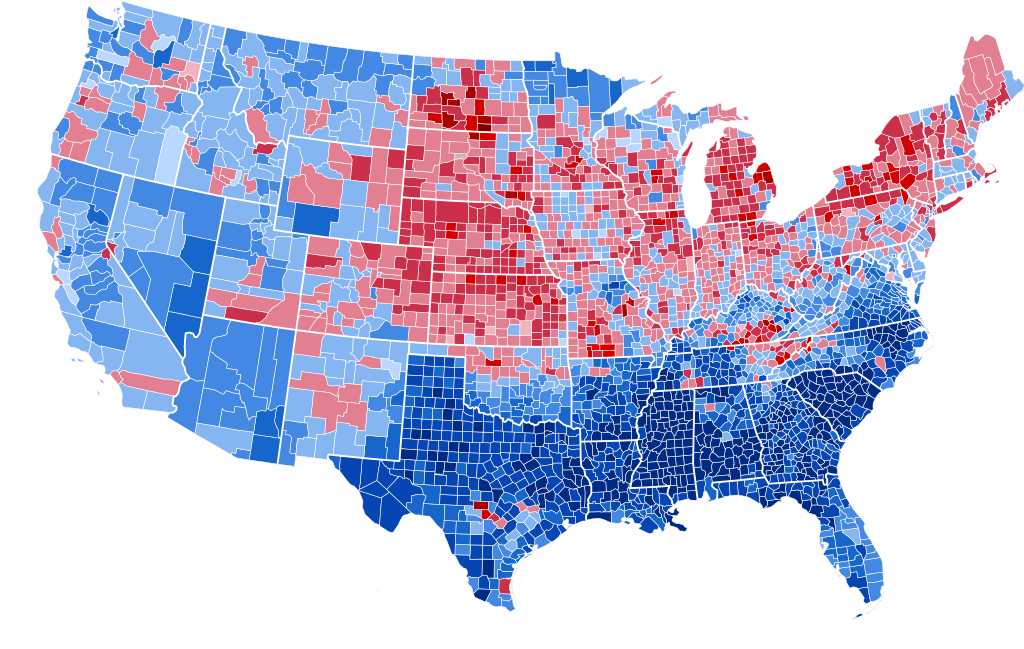

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings
warnings.filterwarnings('ignore')

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [29]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [30]:
def preprocess(df):    
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0

    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def test_preprocess(df):
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def package(preds, df):
    df['Result'][0:] = preds.astype(int)
    return df

In [31]:
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.094595,0.439863,0.384615,0.280161,0.174274,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.355212,0.316151,0.220280,0.160858,0.286307,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.025097,0.391753,0.409091,0.202413,0.219917,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.177606,0.487973,0.174825,0.537534,0.120332,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.247104,0.336770,0.185315,0.089812,0.580913,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.067568,0.384880,0.377622,0.256032,0.248963,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.050193,0.336770,0.356643,0.321716,0.215768,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.030888,0.347079,0.363636,0.195710,0.269710,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.177606,0.443299,0.454545,0.261394,0.190871,0


In [32]:
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",20775,25422,0.413372,0.000832,0.458042,0.431111,0.273611,0.284672,0
1,6035,"Lassen County, CA",3044,7261,0.399213,-0.164725,0.314685,0.355556,0.179167,0.456204,0
2,40081,"Lincoln County, OK",3265,9542,0.371206,-0.023295,0.395105,0.493333,0.181944,0.182482,0
3,31153,"Sarpy County, NE",24709,40318,0.572738,0.066556,0.555944,0.217778,0.508333,0.142336,0
4,28055,"Issaquena County, MS",479,302,0.242874,0.018303,0.300699,0.320000,0.108333,0.642336,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",11695,15406,0.360048,-0.062396,0.409091,0.448889,0.250000,0.339416,0
1551,55031,"Douglas County, WI",14855,7698,0.366363,-0.054077,0.384615,0.404444,0.304167,0.251825,1
1552,27065,"Kanabec County, MN",3586,4319,0.371879,-0.122296,0.248252,0.364444,0.186111,0.328467,0
1553,17139,"Moultrie County, IL",2142,3781,0.427624,0.006656,0.430070,0.528889,0.215278,0.259124,0


In [33]:
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph


,SRC,DST
0,1001,1001
1,1001,1021
2,1001,1047
3,1001,1051
4,1001,1085
...,...,...
12712,72153,72153
12713,78010,78010
12714,78020,78020
12715,78020,78030


In [34]:
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

,FIPS,Result
0,17059,0
1,6103,0
2,42047,0
3,47147,0
4,39039,0
...,...,...
1550,55095,0
1551,34035,0
1552,42107,0
1553,48293,0


In [35]:
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16


,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.335782,-0.050548,0.378947,0.363372,0.126115,0.381910
1,6103,"Tehama County, CA",0.343839,0.008584,0.449123,0.302326,0.197452,0.356784
2,42047,"Elk County, PA",0.417452,-0.044349,0.340351,0.377907,0.236943,0.276382
3,47147,"Robertson County, TN",0.495506,0.035289,0.445614,0.281977,0.236943,0.206030
4,39039,"Defiance County, OH",0.442326,-0.025274,0.389474,0.296512,0.212739,0.246231
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.454619,0.006676,0.333333,0.313953,0.259873,0.231156
1551,34035,"Somerset County, NJ",0.886754,-0.009061,0.354386,0.209302,0.694268,0.206030
1552,42107,"Schuylkill County, PA",0.426136,-0.000477,0.326316,0.389535,0.206369,0.311558
1553,48293,"Limestone County, TX",0.333647,0.002384,0.463158,0.328488,0.178344,0.281407


In [36]:
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.314441,-0.128660,0.299003,0.570796,0.142477,0.351464
1,6103,"Tehama County, CA",0.318161,-0.031056,0.378738,0.420354,0.187750,0.573222
2,42047,"Elk County, PA",0.401674,-0.026619,0.322259,0.548673,0.205060,0.292887
3,47147,"Robertson County, TN",0.445897,-0.039929,0.475083,0.415929,0.225033,0.292887
4,39039,"Defiance County, OH",0.382532,-0.057675,0.385382,0.433628,0.217044,0.322176
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.412586,-0.099379,0.318937,0.371681,0.255659,0.334728
1551,34035,"Somerset County, NJ",0.788239,0.000000,0.345515,0.300885,0.692410,0.309623
1552,42107,"Schuylkill County, PA",0.366433,0.007098,0.328904,0.584071,0.198402,0.405858
1553,48293,"Limestone County, TX",0.300998,0.011535,0.451827,0.469027,0.181092,0.288703


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [37]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search with cross-validation
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [38]:
# Basic Model 2 - SVM with RBF Kernel 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search with cross-validation.
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [39]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [13]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

# Cross-validate on hyperparameters for model selection
best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8294589416858154, 2, 'minkowski']


In [14]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

# Cross-validate on hyperparameters for model selection
best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

[0.8541057735917128, 128.0, 2.6666666666666665]


In [15]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](kaggle_submission_basic.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [47]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# Feature Engineering TODO: 
# graph data get % of neighbors voting D in 2012,
# Model TODO: regularization like https://medium.com/datadriveninvestor/a-simple-way-to-know-how-important-your-input-is-in-neural-network-86cbae0d3689 or/and https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ 
# TODO 

### 3.1.1 Import Statements

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR) # suppress TF warnings from being printed
tf.random.set_seed(123)

from IPython.display import clear_output
from matplotlib import pyplot as plt


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [85]:
def gen_class_weights(df):
    df['Weight'] = 0.0
    # rationale: training data has roughly 5.9 ratio of GOP counties to DEM
    d_weight = 5.0 
    r_weight = 1.0
    # assign weights accordingly
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight
       
    return df

def gen_labels(df):
    # Binary Indicator of Dem or GOP winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
       
    return df

def norm_preprocess(df):    
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col] / factor
    return df

def ratio_preprocess(df):    
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] = mult * d / total_pop
    return df

def cthresh(preds, thresh = 0.5):
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [86]:
# Read train/test data from given CSVs and preprocess the test data

rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = gen_labels(rawdf16)

rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = gen_labels(rawdf12)

dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')

dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')

rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)

rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [87]:
def graph_process(d16, graph, result, result12):
    # Adds extra features to the dataframe based on the graph structure of counties
    # Graph DST sorted least to greatest, other neighbors < DST FIPS can occur but with that DST as SRC
    neigh_exist, neigh_vote, neigh_swing, neigh_pop = [], [], [], []
    for row in range(len(d16)):
        # get current neighbors of county by FIPS
        neighbors = np.array(dfgraph[dfgraph['SRC'] == d16['FIPS'][row]]['DST'][1:])
        neighbors = np.append(neighbors,np.array(dfgraph[dfgraph['DST'] == d16['FIPS'][row]]['SRC'][:-1]))
        prop, swing = [], []
        dem, gop = 0, 0
        for neigh in neighbors:
            if len(result[result['FIPS'] == neigh]) > 0:
                prop = np.append(prop, np.array(result[result['FIPS'] == neigh]['Winner']))
                swing = np.append(swing, np.array(np.abs(np.array(result[result['FIPS'] == neigh]['Winner'])[0] - np.array(result12[result12['FIPS'] == neigh]['Winner'])[0])))
                dem += np.array(result[result['FIPS'] == neigh]['DEM'])[0]
                gop += np.array(result[result['FIPS'] == neigh]['GOP'])[0]
        if len(prop) == 0:
            neigh_vote.append(0.5)
            neigh_exist.append(0)
            neigh_swing.append(0.5)
            neigh_pop.append(0.5)
        else:
            neigh_vote.append(np.mean(prop))
            neigh_exist.append(1)
            neigh_swing.append(np.mean(swing))
            neigh_pop.append(dem / (dem + gop))

    # add feature columns to training data
    d16['neigh_vote'] = np.array(neigh_vote)
    d16['neigh_exist'] = np.array(neigh_exist)
    d16['neigh_swing'] = np.array(neigh_swing)
    d16['neigh_pop'] = np.array(neigh_pop)
    return d16

In [88]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())    
    creative = graph_process(creative.copy(), graph.copy(), df16.copy(), df12.copy())
    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    
    # GENERATE 2012 COLS
    for cols in norm_cols:
        delta = np.array(d12[cols])
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
    
    # GENERATE DIFF COLS
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENERATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative

traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
neigh_vote              float64
neigh_exist               int64
neigh_swing             float64
neigh_pop               float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,...,BachelorRate2012,UnemploymentRate2012,MedianIncomeDiff,MigraRateDiff,BirthRateDiff,DeathRateDiff,BachelorRateDiff,UnemploymentRateDiff,Weight,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.094595,0.439863,0.384615,0.280161,0.174274,...,0.273611,0.284672,0.116587,0.073282,-0.032967,0.110169,0.063492,-0.734694,1.0,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.355212,0.316151,0.220280,0.160858,0.286307,...,0.179167,0.456204,0.100885,0.021374,0.021978,-0.144068,-0.047619,-1.142857,1.0,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.025097,0.391753,0.409091,0.202413,0.219917,...,0.181944,0.182482,0.033367,0.022901,0.010989,0.050847,0.105820,0.061224,1.0,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.177606,0.487973,0.174825,0.537534,0.120332,...,0.508333,0.142336,0.272866,0.018321,-0.186813,0.008475,0.185185,-0.204082,1.0,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.247104,0.336770,0.185315,0.089812,0.580913,...,0.108333,0.642336,-0.084137,-0.229008,0.131868,-0.161017,-0.058201,-0.734694,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.067568,0.384880,0.377622,0.256032,0.248963,...,0.250000,0.339416,0.148384,0.061069,-0.054945,0.059322,0.058201,-0.673469,1.0,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.050193,0.336770,0.356643,0.321716,0.215768,...,0.304167,0.251825,0.295154,0.059542,-0.131868,0.093220,0.111111,-0.346939,5.0,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.030888,0.347079,0.363636,0.195710,0.269710,...,0.186111,0.328467,0.310464,0.248855,0.329670,0.186441,0.063492,-0.510204,1.0,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.177606,0.443299,0.454545,0.261394,0.190871,...,0.215278,0.259124,0.287347,-0.152672,0.065934,0.093220,0.211640,-0.510204,1.0,0


### 3.1.3 Actual Code


In [89]:
print(tf.__version__)

df16 = traindf
test16 = testdf

df16.head()

label_idx = len(df16.columns) - 1
stop_idx = label_idx

trimmed_data_frame = df16.iloc[0:,4:]

train_x = df16.iloc[0:,4:stop_idx]
train_y = df16.iloc[0:,label_idx]
test_x = test16.iloc[0:,2:]

# split = 1555 # splitting idx
split = 1100

N,d = train_x.shape

dftrain = train_x.iloc[:split,:]
y_train = train_y.iloc[:split]
dfeval = train_x.iloc[split:,:]
y_eval = train_y.iloc[split:]

2.3.1


In [113]:
# Constants for use in model
CATEGORICAL_COLUMNS = []
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []
NUMERIC_GRAPH_EXTEND = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]

NUMERIC_GRAPH_EXTEND = ['neigh_vote', 'neigh_swing', 'neigh_pop']

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF
NUMERIC_COLUMNS += NUMERIC_GRAPH_EXTEND

REMOVE = ['MigraRate', 'MigraRate2012', 'BirthRate']
# REMOVE += ['UnemploymentRate2016','BirthRate2012']
NUMERIC_COLUMNS = [x for x in NUMERIC_COLUMNS if x not in REMOVE]

In [120]:
# Model util functions
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

def generate_mini_batch(entire_data_frame, num_rows):
    '''
    Generate a training and validation mini batch from entire_data_frame
    
    Both batches haave size num_rows
    '''
    local_copy = entire_data_frame.copy()
    subdf = local_copy.sample(n = num_rows*2, replace = False)

    # Winner is in last col
    
    label_idx = len(subdf.columns) - 1

    sub_x = subdf.iloc[0:,:label_idx]
    sub_y = subdf.iloc[0:,label_idx]
    
    split = num_rows
    
    valid_x = sub_x.iloc[split:,:]
    valid_y = sub_y.iloc[split:]    
    sub_x = sub_x.iloc[:split,:]
    sub_y = sub_y.iloc[:split]
  
    
    return sub_x, sub_y, valid_x, valid_y

[ *** ] STEP MAX: 50
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                 0.742500
accuracy_baseline        0.531250
auc                      0.829396
auc_precision_recall     0.814258
average_loss             0.584336
label/mean               0.468750
loss                     0.934938
precision                0.755287
prediction/mean          0.462154
recall                   0.666667
global_step             50.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7380392156862746
[ $ ] VALIDATION ACCURACY OVER TIME: 


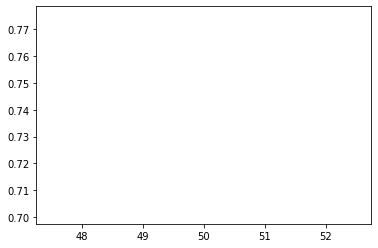

[ $$$ ] TEST


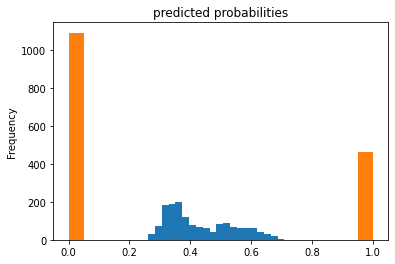

[ *** ] STEP MAX: 100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.781421
accuracy_baseline         0.603825
auc                       0.857252
auc_precision_recall      0.807553
average_loss              0.503109
label/mean                0.396175
loss                      0.736552
precision                 0.716667
prediction/mean           0.452297
recall                    0.741379
global_step             100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7745358090185676
[ $ ] VALIDATION ACCURACY OVER TIME: 


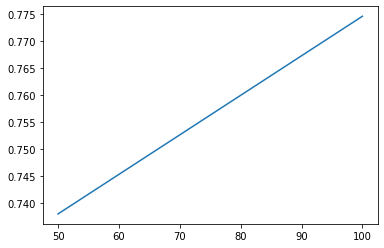

[ $$$ ] TEST


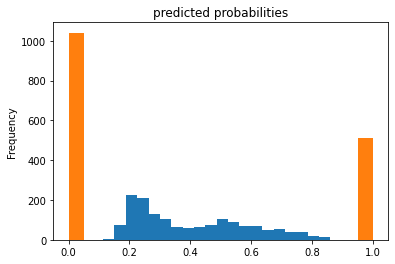

[ *** ] STEP MAX: 150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.788071
accuracy_baseline         0.543147
auc                       0.875373
auc_precision_recall      0.845122
average_loss              0.463761
label/mean                0.456853
loss                      0.730888
precision                 0.814332
prediction/mean           0.432603
recall                    0.694444
global_step             150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7806334371754933
[ $ ] VALIDATION ACCURACY OVER TIME: 


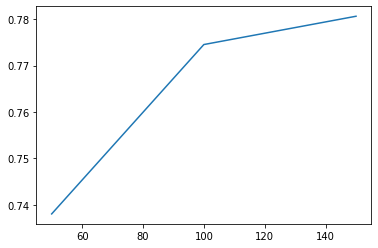

[ $$$ ] TEST


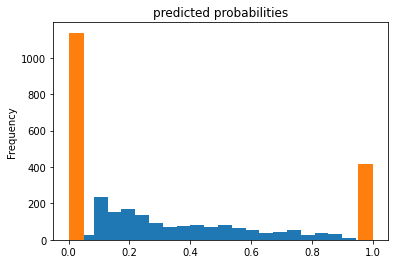

[ *** ] STEP MAX: 200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.802419
accuracy_baseline         0.590054
auc                       0.901434
auc_precision_recall      0.863296
average_loss              0.424414
label/mean                0.409946
loss                      0.631528
precision                 0.724432
prediction/mean           0.494821
recall                    0.836066
global_step             200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.807554426976362
[ $ ] VALIDATION ACCURACY OVER TIME: 


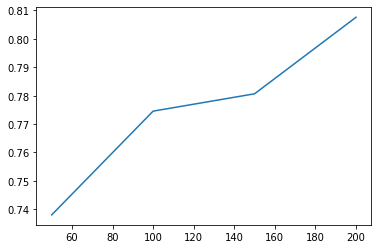

[ $$$ ] TEST


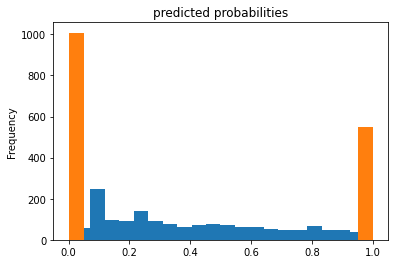

[ *** ] STEP MAX: 250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.777926
accuracy_baseline         0.581117
auc                       0.863300
auc_precision_recall      0.816901
average_loss              0.454386
label/mean                0.418883
loss                      0.683396
precision                 0.772059
prediction/mean           0.383660
recall                    0.666667
global_step             250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7623951182303585
[ $ ] VALIDATION ACCURACY OVER TIME: 


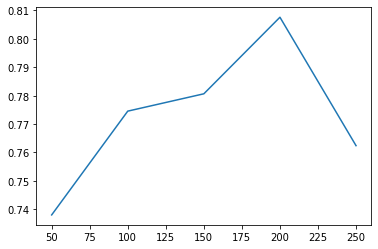

[ $$$ ] TEST


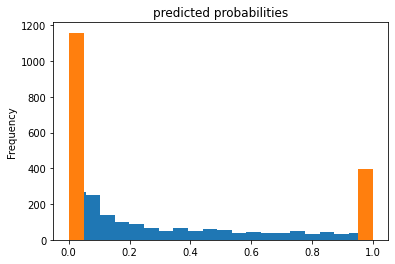

[ *** ] STEP MAX: 300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.804569
accuracy_baseline         0.543147
auc                       0.883616
auc_precision_recall      0.871831
average_loss              0.431155
label/mean                0.456853
loss                      0.679501
precision                 0.790960
prediction/mean           0.456013
recall                    0.777778
global_step             300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8024402907580478
[ $ ] VALIDATION ACCURACY OVER TIME: 


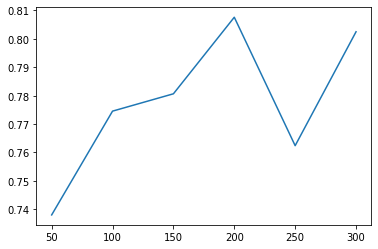

[ $$$ ] TEST


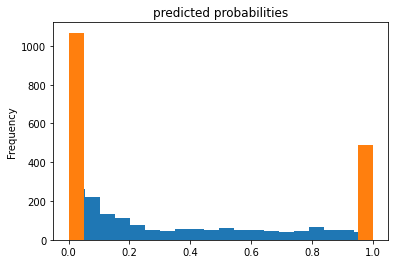

[ *** ] STEP MAX: 350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.815854
accuracy_baseline         0.512195
auc                       0.916429
auc_precision_recall      0.907757
average_loss              0.377348
label/mean                0.487805
loss                      0.618851
precision                 0.835580
prediction/mean           0.452307
recall                    0.775000
global_step             350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8148809523809523
[ $ ] VALIDATION ACCURACY OVER TIME: 


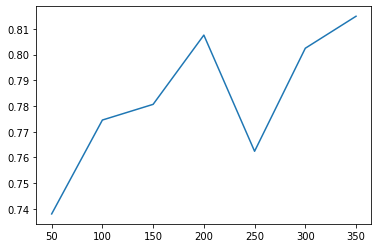

[ $$$ ] TEST


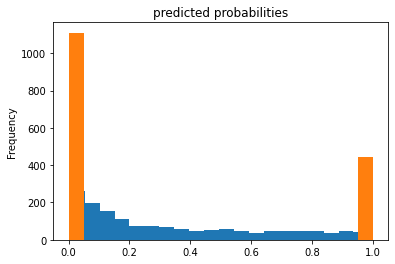

[ *** ] STEP MAX: 400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.823077
accuracy_baseline         0.551282
auc                       0.912425
auc_precision_recall      0.891137
average_loss              0.376851
label/mean                0.448718
loss                      0.587887
precision                 0.796089
prediction/mean           0.453521
recall                    0.814286
global_step             400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8222591362126245
[ $ ] VALIDATION ACCURACY OVER TIME: 


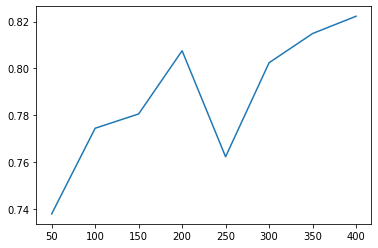

[ $$$ ] TEST


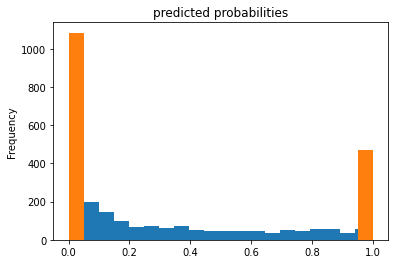

[ *** ] STEP MAX: 450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.808081
accuracy_baseline         0.539141
auc                       0.912659
auc_precision_recall      0.897192
average_loss              0.377324
label/mean                0.460859
loss                      0.597681
precision                 0.825688
prediction/mean           0.431064
recall                    0.739726
global_step             450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8031182830194732
[ $ ] VALIDATION ACCURACY OVER TIME: 


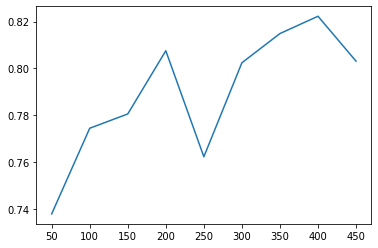

[ $$$ ] TEST


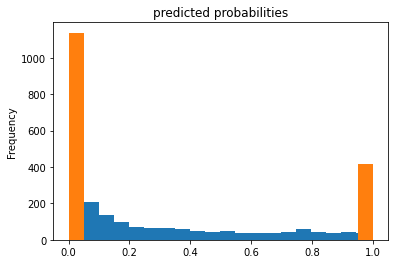

[ *** ] STEP MAX: 500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.881980
accuracy_baseline         0.543147
auc                       0.942854
auc_precision_recall      0.931670
average_loss              0.321289
label/mean                0.456853
loss                      0.506351
precision                 0.857909
prediction/mean           0.448332
recall                    0.888889
global_step             500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8825285565939771
[ $ ] VALIDATION ACCURACY OVER TIME: 


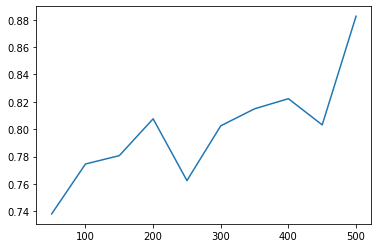

[ $$$ ] TEST


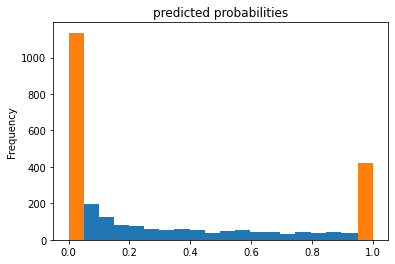

[ *** ] STEP MAX: 550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.849246
accuracy_baseline         0.535176
auc                       0.939031
auc_precision_recall      0.929218
average_loss              0.329052
label/mean                0.464824
loss                      0.523850
precision                 0.867647
prediction/mean           0.427612
recall                    0.797297
global_step             550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8458317472401979
[ $ ] VALIDATION ACCURACY OVER TIME: 


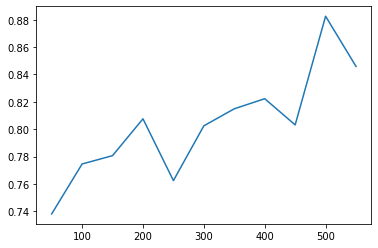

[ $$$ ] TEST


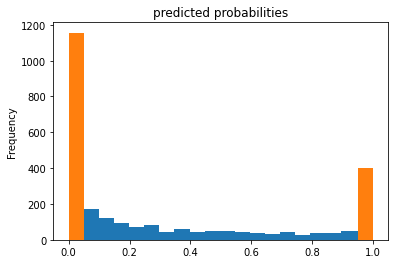

[ *** ] STEP MAX: 600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.840452
accuracy_baseline         0.535176
auc                       0.931846
auc_precision_recall      0.916235
average_loss              0.333550
label/mean                0.464824
loss                      0.531012
precision                 0.822281
prediction/mean           0.468021
recall                    0.837838
global_step             600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8402804212663368
[ $ ] VALIDATION ACCURACY OVER TIME: 


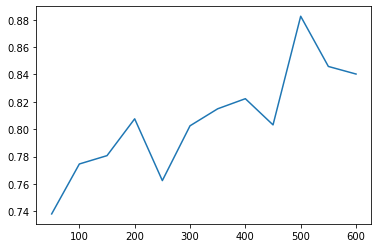

[ $$$ ] TEST


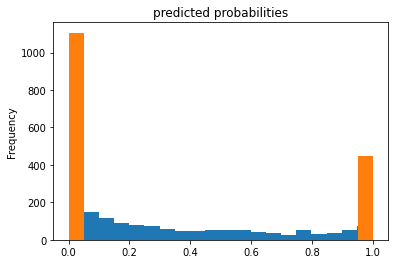

[ *** ] STEP MAX: 650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.855198
accuracy_baseline         0.523515
auc                       0.945673
auc_precision_recall      0.942204
average_loss              0.307284
label/mean                0.476485
loss                      0.496571
precision                 0.870166
prediction/mean           0.453479
recall                    0.818182
global_step             650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8535353535353535
[ $ ] VALIDATION ACCURACY OVER TIME: 


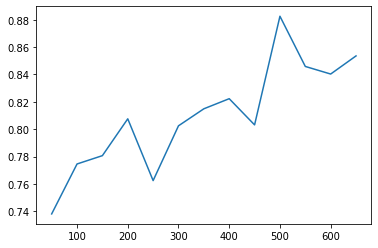

[ $$$ ] TEST


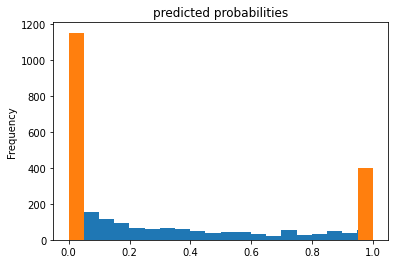

[ *** ] STEP MAX: 700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.849747
accuracy_baseline         0.539141
auc                       0.939383
auc_precision_recall      0.923343
average_loss              0.312919
label/mean                0.460859
loss                      0.495664
precision                 0.837912
prediction/mean           0.458695
recall                    0.835616
global_step             700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8487215681242181
[ $ ] VALIDATION ACCURACY OVER TIME: 


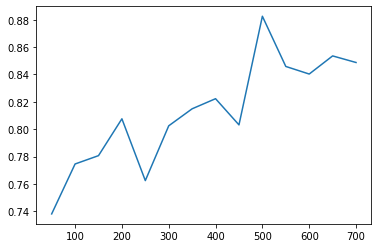

[ $$$ ] TEST


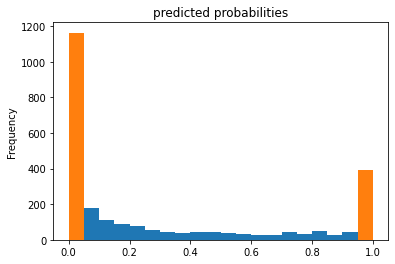

[ *** ] STEP MAX: 750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.830645
accuracy_baseline         0.590054
auc                       0.912394
auc_precision_recall      0.865796
average_loss              0.375230
label/mean                0.409946
loss                      0.558342
precision                 0.818505
prediction/mean           0.388986
recall                    0.754098
global_step             750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8189626199634041
[ $ ] VALIDATION ACCURACY OVER TIME: 


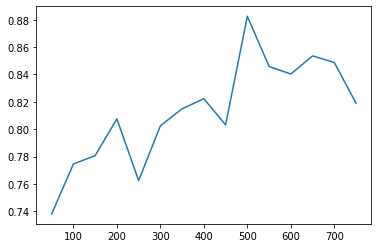

[ $$$ ] TEST


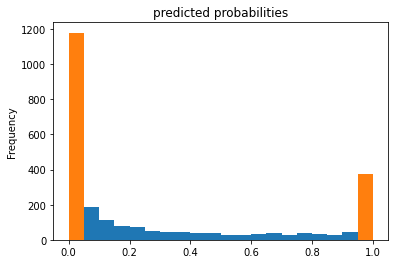

[ *** ] STEP MAX: 800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.855911
accuracy_baseline         0.519704
auc                       0.932495
auc_precision_recall      0.919133
average_loss              0.341077
label/mean                0.480296
loss                      0.553909
precision                 0.882353
prediction/mean           0.431207
recall                    0.807692
global_step             800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8540831206707985
[ $ ] VALIDATION ACCURACY OVER TIME: 


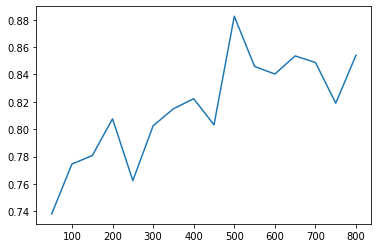

[ $$$ ] TEST


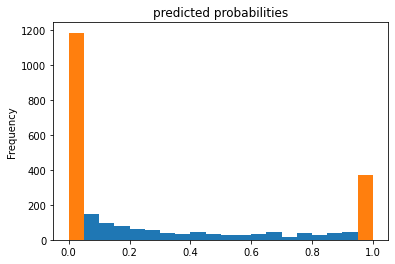

[ *** ] STEP MAX: 850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.817500
accuracy_baseline         0.531250
auc                       0.933098
auc_precision_recall      0.920681
average_loss              0.348636
label/mean                0.468750
loss                      0.557818
precision                 0.880399
prediction/mean           0.393583
recall                    0.706667
global_step             850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8109803921568628
[ $ ] VALIDATION ACCURACY OVER TIME: 


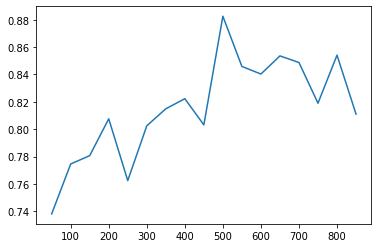

[ $$$ ] TEST


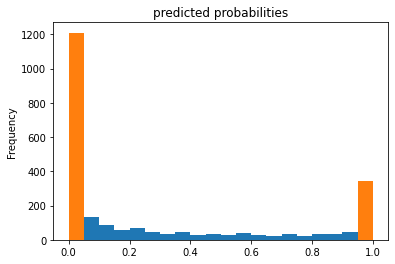

[ *** ] STEP MAX: 900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.833333
accuracy_baseline         0.563802
auc                       0.929268
auc_precision_recall      0.910525
average_loss              0.336506
label/mean                0.436198
loss                      0.516874
precision                 0.820433
prediction/mean           0.425530
recall                    0.791045
global_step             900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8285477922167455
[ $ ] VALIDATION ACCURACY OVER TIME: 


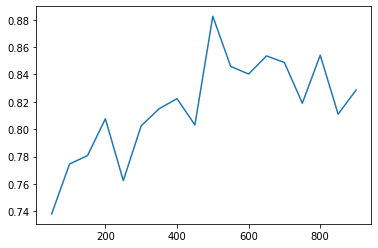

[ $$$ ] TEST


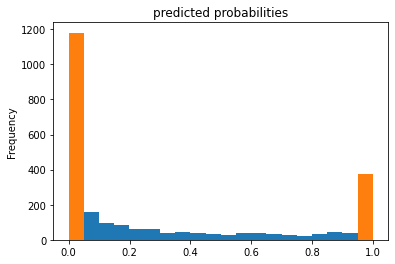

[ *** ] STEP MAX: 950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.864322
accuracy_baseline         0.535176
auc                       0.946168
auc_precision_recall      0.933765
average_loss              0.297990
label/mean                0.464824
loss                      0.474400
precision                 0.876437
prediction/mean           0.436783
recall                    0.824324
global_step             950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.861692678594087
[ $ ] VALIDATION ACCURACY OVER TIME: 


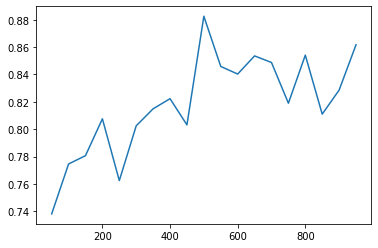

[ $$$ ] TEST


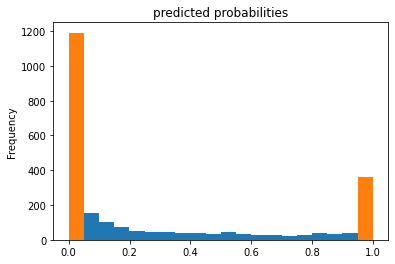

[ *** ] STEP MAX: 1000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.885678
accuracy_baseline          0.535176
auc                        0.944217
auc_precision_recall       0.925604
average_loss               0.303569
label/mean                 0.464824
loss                       0.483282
precision                  0.866142
prediction/mean            0.466741
recall                     0.891892
global_step             1000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8860867910163686
[ $ ] VALIDATION ACCURACY OVER TIME: 


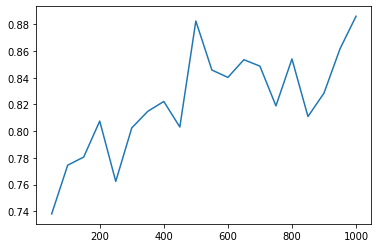

[ $$$ ] TEST


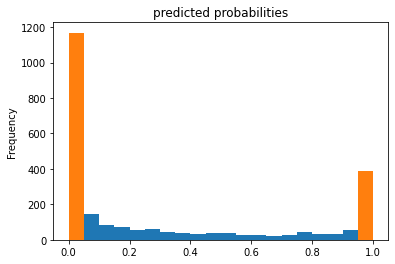

[ *** ] STEP MAX: 1050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.863520
accuracy_baseline          0.547194
auc                        0.948652
auc_precision_recall       0.935749
average_loss               0.288708
label/mean                 0.452806
loss                       0.452694
precision                  0.862573
prediction/mean            0.430310
recall                     0.830986
global_step             1050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8607144029679241
[ $ ] VALIDATION ACCURACY OVER TIME: 


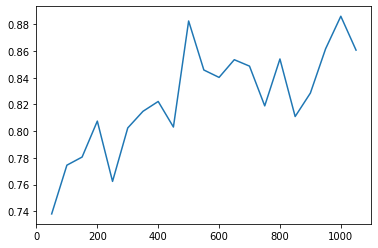

[ $$$ ] TEST


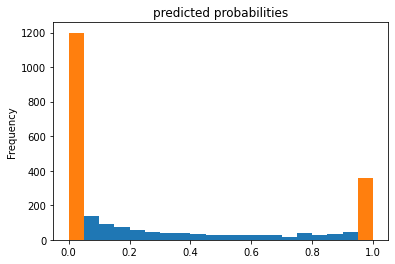

[ *** ] STEP MAX: 1100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.863636
accuracy_baseline          0.539141
auc                        0.948414
auc_precision_recall       0.931328
average_loss               0.288431
label/mean                 0.460859
loss                       0.456875
precision                  0.826972
prediction/mean            0.481792
recall                     0.890411
global_step             1100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.865580186712008
[ $ ] VALIDATION ACCURACY OVER TIME: 


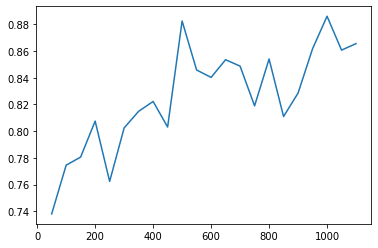

[ $$$ ] TEST


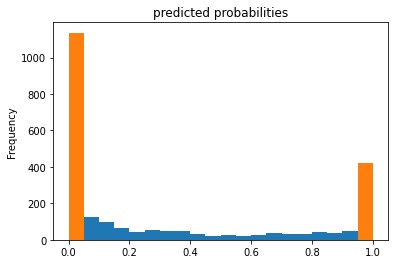

[ *** ] STEP MAX: 1150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.904229
accuracy_baseline          0.527363
auc                        0.957935
auc_precision_recall       0.943809
average_loss               0.264884
label/mean                 0.472637
loss                       0.425934
precision                  0.881612
prediction/mean            0.455912
recall                     0.921053
global_step             1150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9051017874875869
[ $ ] VALIDATION ACCURACY OVER TIME: 


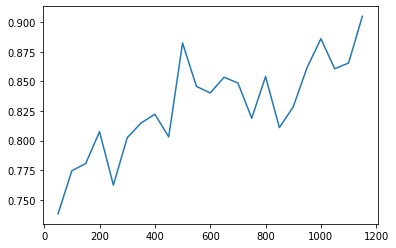

[ $$$ ] TEST


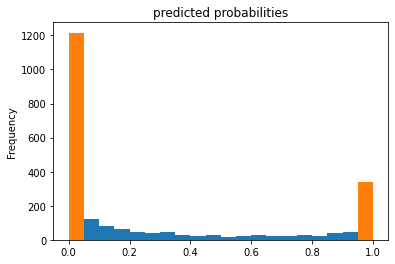

[ *** ] STEP MAX: 1200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.858639
accuracy_baseline          0.568063
auc                        0.940668
auc_precision_recall       0.920435
average_loss               0.316675
label/mean                 0.431937
loss                       0.483880
precision                  0.872483
prediction/mean            0.395175
recall                     0.787879
global_step             1200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.850160592096076
[ $ ] VALIDATION ACCURACY OVER TIME: 


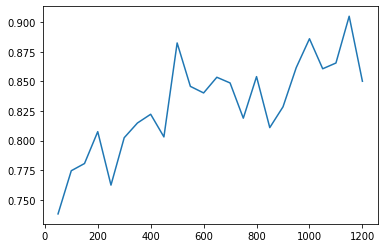

[ $$$ ] TEST


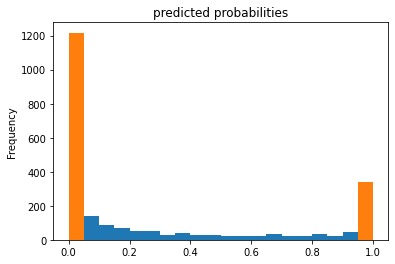

[ *** ] STEP MAX: 1250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.861842
accuracy_baseline          0.572368
auc                        0.951441
auc_precision_recall       0.925815
average_loss               0.277231
label/mean                 0.427632
loss                       0.421390
precision                  0.866667
prediction/mean            0.413637
recall                     0.800000
global_step             1250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8540229885057471
[ $ ] VALIDATION ACCURACY OVER TIME: 


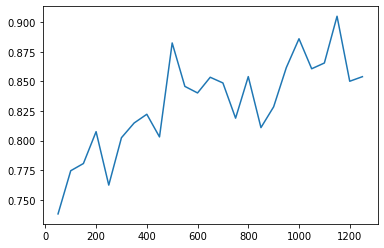

[ $$$ ] TEST


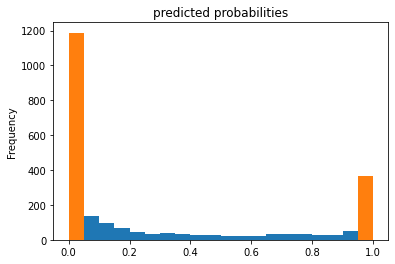

[ *** ] STEP MAX: 1300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866402
accuracy_baseline          0.576720
auc                        0.938127
auc_precision_recall       0.913275
average_loss               0.323336
label/mean                 0.423280
loss                       0.488884
precision                  0.863787
prediction/mean            0.400085
recall                     0.812500
global_step             1300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8592316513761469
[ $ ] VALIDATION ACCURACY OVER TIME: 


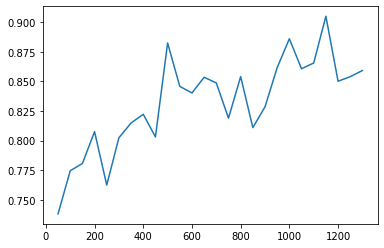

[ $$$ ] TEST


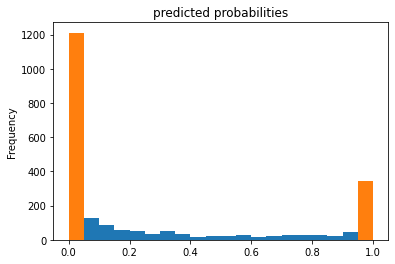

[ *** ] STEP MAX: 1350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.875654
accuracy_baseline          0.568063
auc                        0.950985
auc_precision_recall       0.932861
average_loss               0.281338
label/mean                 0.431937
loss                       0.429884
precision                  0.840580
prediction/mean            0.446690
recall                     0.878788
global_step             1350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8760298840944002
[ $ ] VALIDATION ACCURACY OVER TIME: 


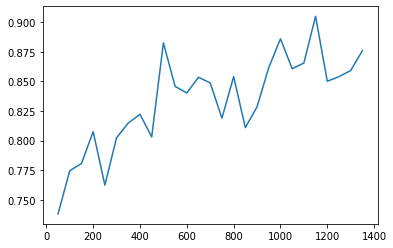

[ $$$ ] TEST


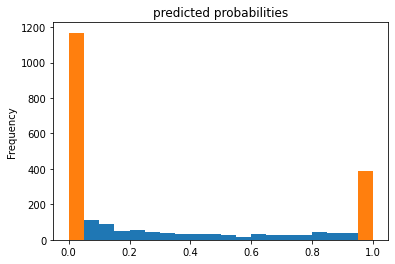

[ *** ] STEP MAX: 1400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.896373
accuracy_baseline          0.559586
auc                        0.965363
auc_precision_recall       0.942866
average_loss               0.246337
label/mean                 0.440415
loss                       0.380344
precision                  0.861111
prediction/mean            0.458286
recall                     0.911765
global_step             1400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8980119825708062
[ $ ] VALIDATION ACCURACY OVER TIME: 


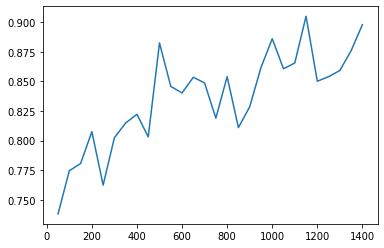

[ $$$ ] TEST


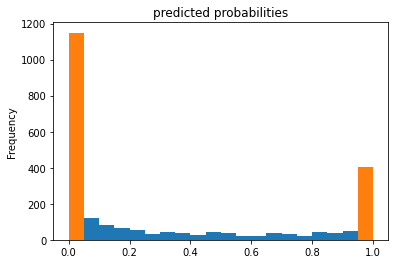

[ *** ] STEP MAX: 1450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.856250
accuracy_baseline          0.531250
auc                        0.953082
auc_precision_recall       0.945837
average_loss               0.286849
label/mean                 0.468750
loss                       0.458958
precision                  0.871429
prediction/mean            0.436749
recall                     0.813333
global_step             1450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8537254901960785
[ $ ] VALIDATION ACCURACY OVER TIME: 


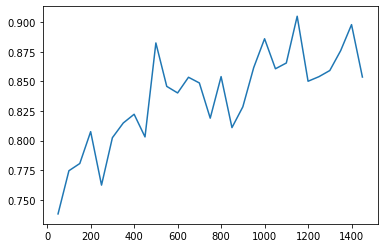

[ $$$ ] TEST


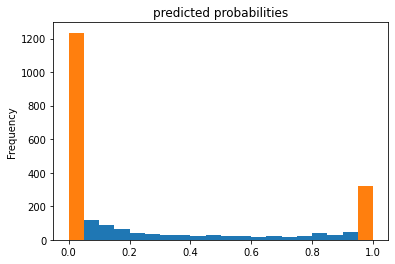

[ *** ] STEP MAX: 1500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.837438
accuracy_baseline          0.519704
auc                        0.937082
auc_precision_recall       0.925293
average_loss               0.315845
label/mean                 0.480296
loss                       0.512932
precision                  0.846774
prediction/mean            0.443567
recall                     0.807692
global_step             1500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8363106088224572
[ $ ] VALIDATION ACCURACY OVER TIME: 


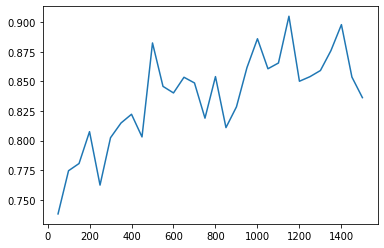

[ $$$ ] TEST


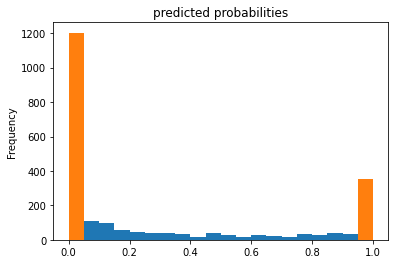

[ *** ] STEP MAX: 1550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.860677
accuracy_baseline          0.563802
auc                        0.938558
auc_precision_recall       0.915051
average_loss               0.319722
label/mean                 0.436198
loss                       0.491093
precision                  0.877483
prediction/mean            0.401394
recall                     0.791045
global_step             1550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.85279721484954
[ $ ] VALIDATION ACCURACY OVER TIME: 


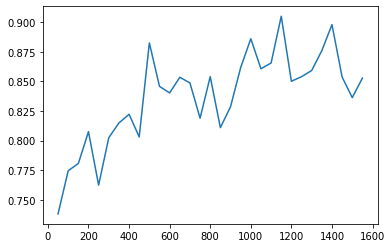

[ $$$ ] TEST


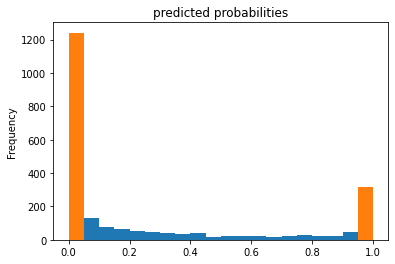

[ *** ] STEP MAX: 1600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.890789
accuracy_baseline          0.572368
auc                        0.951759
auc_precision_recall       0.937759
average_loss               0.283834
label/mean                 0.427632
loss                       0.431428
precision                  0.880503
prediction/mean            0.409233
recall                     0.861538
global_step             1600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8870910698496905
[ $ ] VALIDATION ACCURACY OVER TIME: 


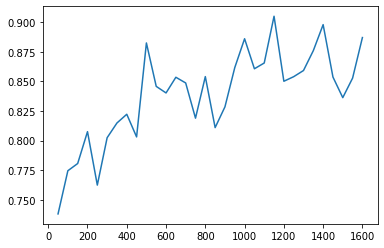

[ $$$ ] TEST


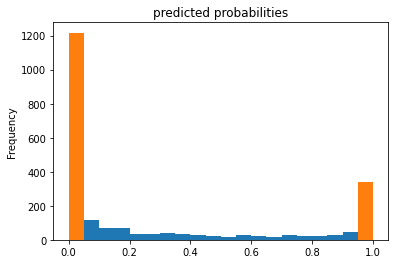

[ *** ] STEP MAX: 1650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.895833
accuracy_baseline          0.563802
auc                        0.962945
auc_precision_recall       0.952285
average_loss               0.247368
label/mean                 0.436198
loss                       0.379957
precision                  0.892308
prediction/mean            0.423756
recall                     0.865672
global_step             1650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8924201165075317
[ $ ] VALIDATION ACCURACY OVER TIME: 


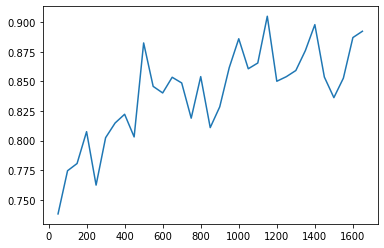

[ $$$ ] TEST


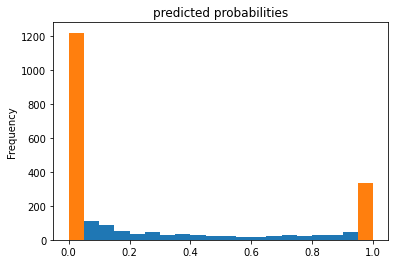

[ *** ] STEP MAX: 1700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866250
accuracy_baseline          0.531250
auc                        0.952502
auc_precision_recall       0.941218
average_loss               0.281517
label/mean                 0.468750
loss                       0.450427
precision                  0.891813
prediction/mean            0.425709
recall                     0.813333
global_step             1700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8631372549019609
[ $ ] VALIDATION ACCURACY OVER TIME: 


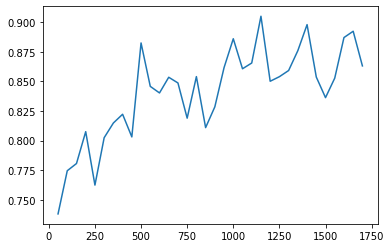

[ $$$ ] TEST


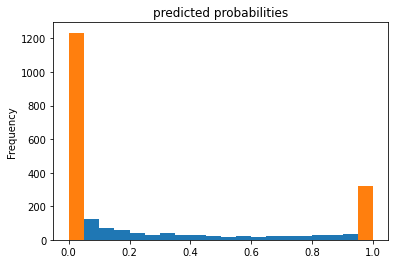

[ *** ] STEP MAX: 1750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.872368
accuracy_baseline          0.572368
auc                        0.953616
auc_precision_recall       0.933241
average_loss               0.278530
label/mean                 0.427632
loss                       0.423365
precision                  0.833333
prediction/mean            0.451410
recall                     0.876923
global_step             1750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8729442970822282
[ $ ] VALIDATION ACCURACY OVER TIME: 


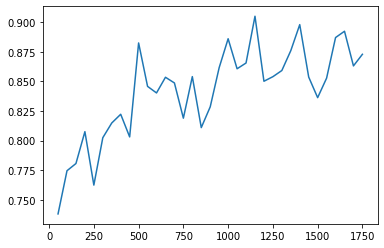

[ $$$ ] TEST


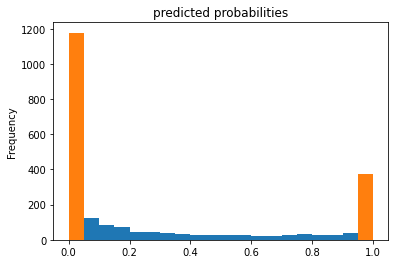

[ *** ] STEP MAX: 1800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.892857
accuracy_baseline          0.547194
auc                        0.963623
auc_precision_recall       0.950743
average_loss               0.249967
label/mean                 0.452806
loss                       0.391949
precision                  0.899705
prediction/mean            0.427815
recall                     0.859155
global_step             1800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8899504251616928
[ $ ] VALIDATION ACCURACY OVER TIME: 


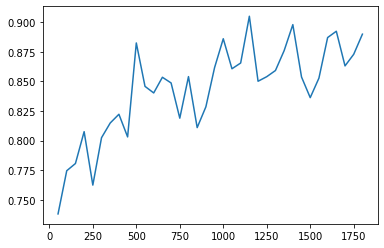

[ $$$ ] TEST


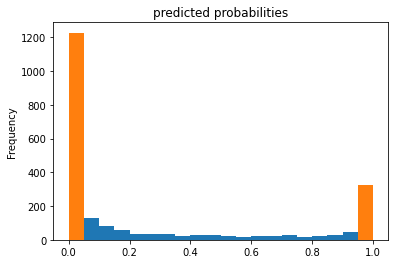

[ *** ] STEP MAX: 1850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.909898
accuracy_baseline          0.543147
auc                        0.964499
auc_precision_recall       0.957221
average_loss               0.240818
label/mean                 0.456853
loss                       0.379529
precision                  0.879265
prediction/mean            0.464373
recall                     0.930556
global_step             1850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9115394600207685
[ $ ] VALIDATION ACCURACY OVER TIME: 


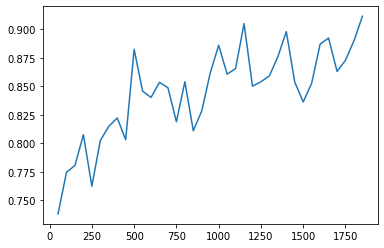

[ $$$ ] TEST


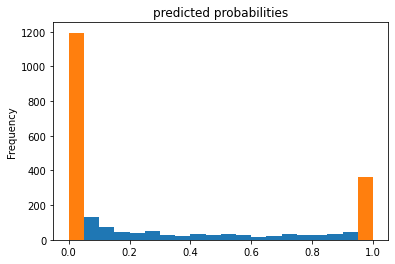

[ *** ] STEP MAX: 1900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.868873
accuracy_baseline          0.515931
auc                        0.948811
auc_precision_recall       0.941043
average_loss               0.327067
label/mean                 0.484069
loss                       0.533774
precision                  0.909091
prediction/mean            0.413781
recall                     0.810127
global_step             1900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8670585405454162
[ $ ] VALIDATION ACCURACY OVER TIME: 


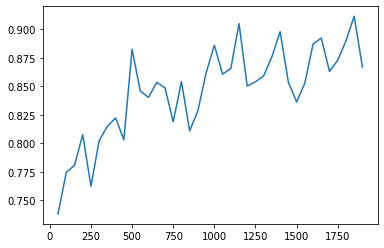

[ $$$ ] TEST


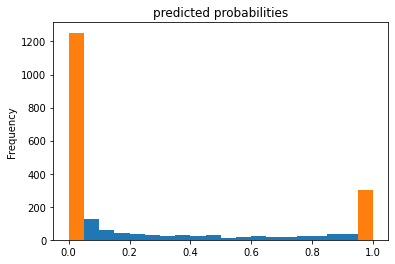

[ *** ] STEP MAX: 1950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.906085
accuracy_baseline          0.576720
auc                        0.970040
auc_precision_recall       0.957889
average_loss               0.221762
label/mean                 0.423280
loss                       0.335304
precision                  0.854701
prediction/mean            0.446795
recall                     0.937500
global_step             1950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9102637614678899
[ $ ] VALIDATION ACCURACY OVER TIME: 


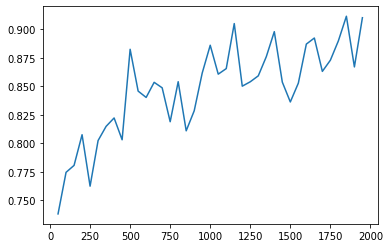

[ $$$ ] TEST


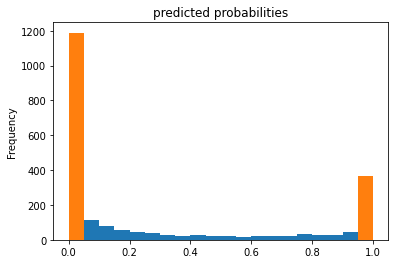

[ *** ] STEP MAX: 2000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.902850
accuracy_baseline          0.559586
auc                        0.960733
auc_precision_recall       0.948628
average_loss               0.250035
label/mean                 0.440415
loss                       0.386054
precision                  0.873239
prediction/mean            0.433763
recall                     0.911765
global_step             2000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9037990196078431
[ $ ] VALIDATION ACCURACY OVER TIME: 


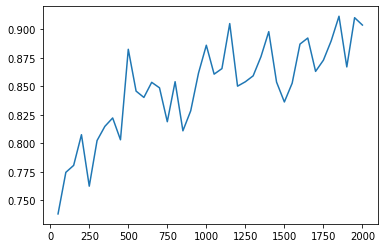

[ $$$ ] TEST


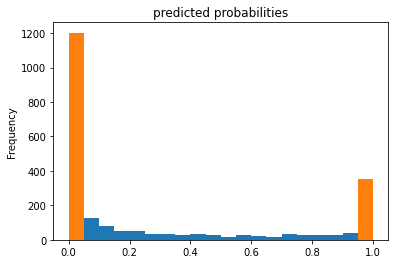

[ *** ] STEP MAX: 2050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866250
accuracy_baseline          0.531250
auc                        0.960722
auc_precision_recall       0.948667
average_loss               0.257292
label/mean                 0.468750
loss                       0.411667
precision                  0.880682
prediction/mean            0.442901
recall                     0.826667
global_step             2050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8639215686274511
[ $ ] VALIDATION ACCURACY OVER TIME: 


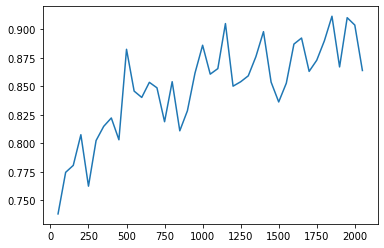

[ $$$ ] TEST


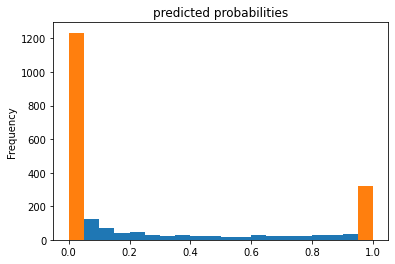

[ *** ] STEP MAX: 2100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.890152
accuracy_baseline          0.539141
auc                        0.965401
auc_precision_recall       0.958570
average_loss               0.235540
label/mean                 0.460859
loss                       0.373095
precision                  0.894886
prediction/mean            0.439936
recall                     0.863014
global_step             2100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8881813223829843
[ $ ] VALIDATION ACCURACY OVER TIME: 


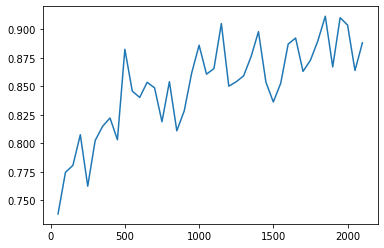

[ $$$ ] TEST


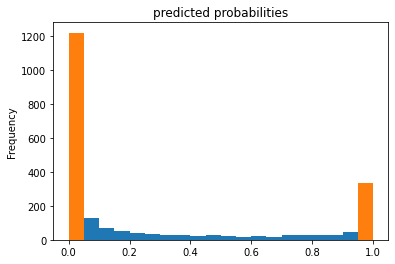

[ *** ] STEP MAX: 2150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.894330
accuracy_baseline          0.555412
auc                        0.971401
auc_precision_recall       0.964697
average_loss               0.223656
label/mean                 0.444588
loss                       0.347114
precision                  0.858311
prediction/mean            0.475660
recall                     0.913043
global_step             2150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8961969131443559
[ $ ] VALIDATION ACCURACY OVER TIME: 


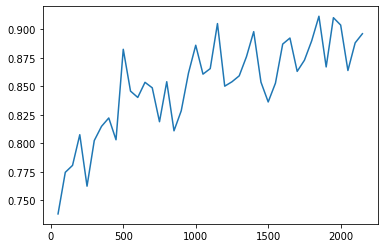

[ $$$ ] TEST


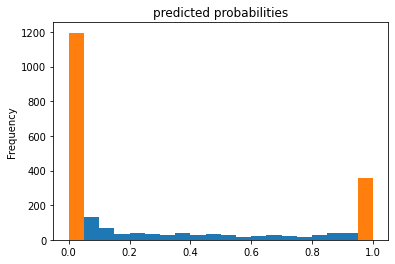

[ *** ] STEP MAX: 2200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.869458
accuracy_baseline          0.519704
auc                        0.947427
auc_precision_recall       0.936782
average_loss               0.328326
label/mean                 0.480296
loss                       0.533202
precision                  0.910405
prediction/mean            0.405053
recall                     0.807692
global_step             2200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8671162960262486
[ $ ] VALIDATION ACCURACY OVER TIME: 


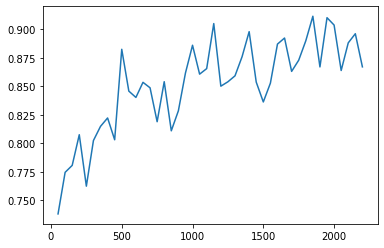

[ $$$ ] TEST


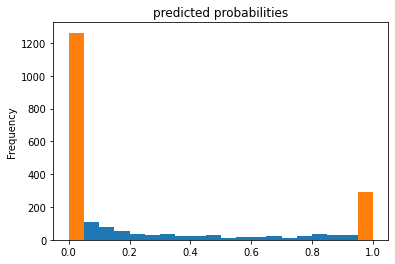

[ *** ] STEP MAX: 2250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.856098
accuracy_baseline          0.512195
auc                        0.949464
auc_precision_recall       0.943143
average_loss               0.325246
label/mean                 0.487805
loss                       0.533404
precision                  0.905172
prediction/mean            0.418719
recall                     0.787500
global_step             2250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8544642857142858
[ $ ] VALIDATION ACCURACY OVER TIME: 


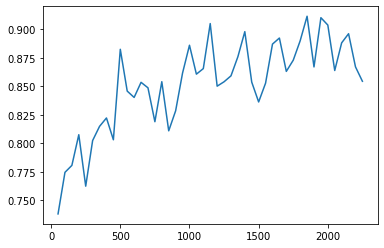

[ $$$ ] TEST


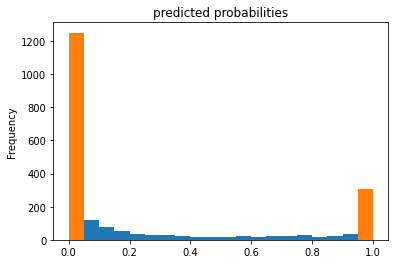

[ *** ] STEP MAX: 2300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.881127
accuracy_baseline          0.515931
auc                        0.959770
auc_precision_recall       0.953626
average_loss               0.271555
label/mean                 0.484069
loss                       0.443178
precision                  0.911602
prediction/mean            0.432463
recall                     0.835443
global_step             2300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8797167683935174
[ $ ] VALIDATION ACCURACY OVER TIME: 


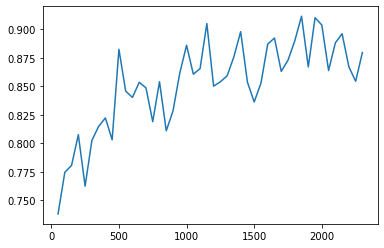

[ $$$ ] TEST


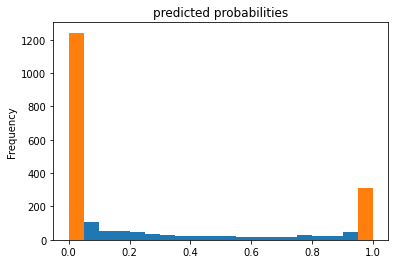

[ *** ] STEP MAX: 2350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.901316
accuracy_baseline          0.572368
auc                        0.963820
auc_precision_recall       0.950259
average_loss               0.244641
label/mean                 0.427632
loss                       0.371854
precision                  0.890625
prediction/mean            0.405098
recall                     0.876923
global_step             2350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8982316534040673
[ $ ] VALIDATION ACCURACY OVER TIME: 


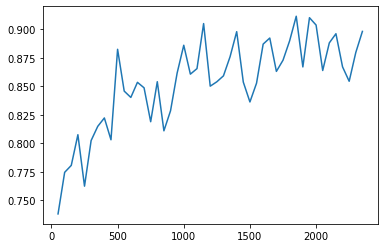

[ $$$ ] TEST


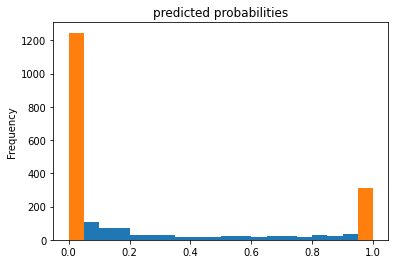

[ *** ] STEP MAX: 2400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.831633
accuracy_baseline          0.547194
auc                        0.947487
auc_precision_recall       0.932548
average_loss               0.317275
label/mean                 0.452806
loss                       0.497488
precision                  0.888502
prediction/mean            0.382875
recall                     0.718310
global_step             2400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8218588922814275
[ $ ] VALIDATION ACCURACY OVER TIME: 


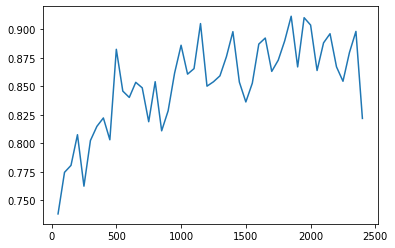

[ $$$ ] TEST


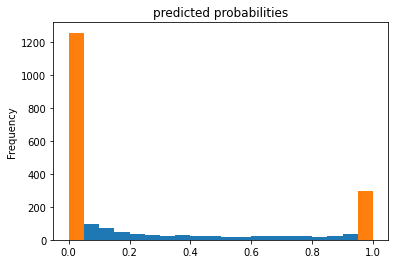

[ *** ] STEP MAX: 2450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.891582
accuracy_baseline          0.547194
auc                        0.968614
auc_precision_recall       0.962577
average_loss               0.224431
label/mean                 0.452806
loss                       0.351908
precision                  0.875000
prediction/mean            0.446907
recall                     0.887324
global_step             2450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8912144193834336
[ $ ] VALIDATION ACCURACY OVER TIME: 


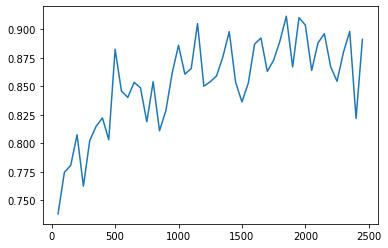

[ $$$ ] TEST


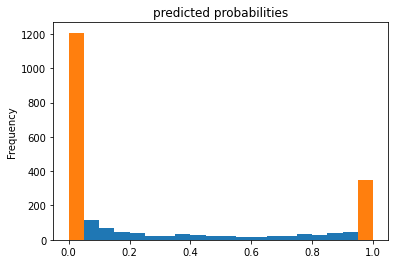

[ *** ] STEP MAX: 2500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866422
accuracy_baseline          0.515931
auc                        0.963649
auc_precision_recall       0.958621
average_loss               0.270897
label/mean                 0.484069
loss                       0.442104
precision                  0.915698
prediction/mean            0.420207
recall                     0.797468
global_step             2500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8642923719895366
[ $ ] VALIDATION ACCURACY OVER TIME: 


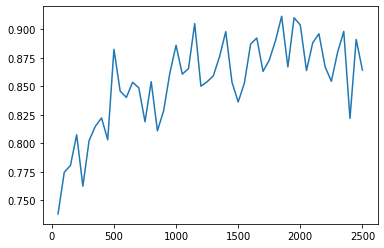

[ $$$ ] TEST


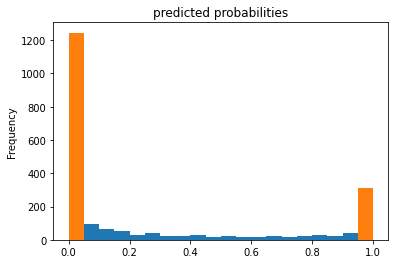

[ *** ] STEP MAX: 2550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.859694
accuracy_baseline          0.547194
auc                        0.955120
auc_precision_recall       0.947142
average_loss               0.286207
label/mean                 0.452806
loss                       0.448773
precision                  0.876923
prediction/mean            0.407670
recall                     0.802817
global_step             2550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8547884040841789
[ $ ] VALIDATION ACCURACY OVER TIME: 


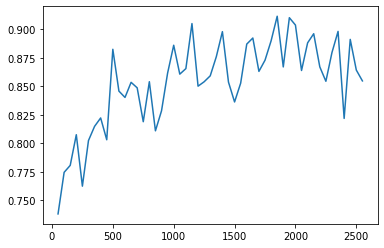

[ $$$ ] TEST


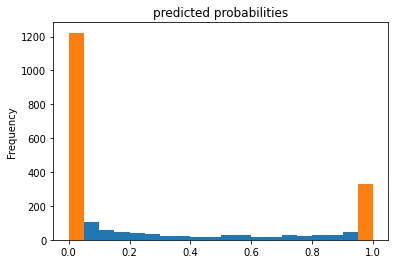

[ *** ] STEP MAX: 2600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.876829
accuracy_baseline          0.512195
auc                        0.955699
auc_precision_recall       0.944950
average_loss               0.290804
label/mean                 0.487805
loss                       0.476919
precision                  0.914127
prediction/mean            0.431960
recall                     0.825000
global_step             2600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8755952380952381
[ $ ] VALIDATION ACCURACY OVER TIME: 


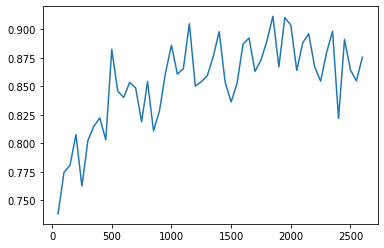

[ $$$ ] TEST


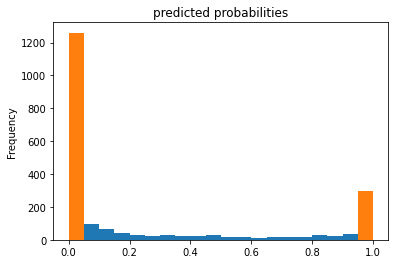

[ *** ] STEP MAX: 2650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866580
accuracy_baseline          0.559586
auc                        0.953346
auc_precision_recall       0.937362
average_loss               0.288118
label/mean                 0.440415
loss                       0.444854
precision                  0.878594
prediction/mean            0.409411
recall                     0.808824
global_step             2650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.860430283224401
[ $ ] VALIDATION ACCURACY OVER TIME: 


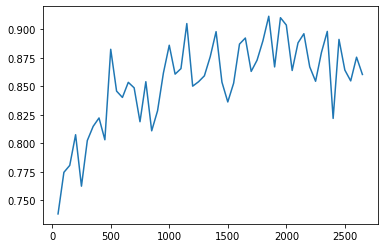

[ $$$ ] TEST


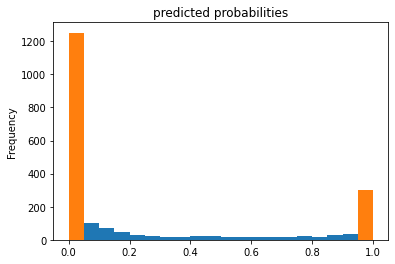

[ *** ] STEP MAX: 2700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.897668
accuracy_baseline          0.559586
auc                        0.972222
auc_precision_recall       0.965993
average_loss               0.223009
label/mean                 0.440415
loss                       0.344326
precision                  0.909091
prediction/mean            0.403845
recall                     0.852941
global_step             2700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8929057734204794
[ $ ] VALIDATION ACCURACY OVER TIME: 


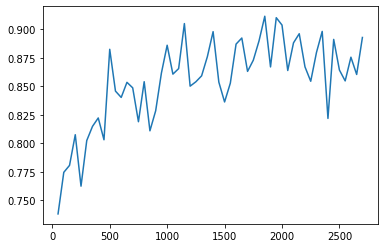

[ $$$ ] TEST


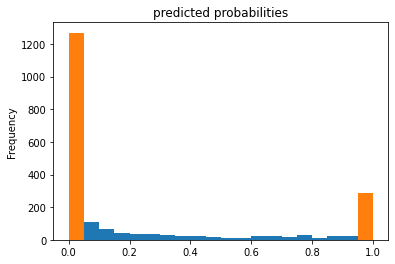

[ *** ] STEP MAX: 2750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.878079
accuracy_baseline          0.519704
auc                        0.955979
auc_precision_recall       0.944403
average_loss               0.281647
label/mean                 0.480296
loss                       0.457394
precision                  0.905292
prediction/mean            0.434080
recall                     0.833333
global_step             2750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8763823064770931
[ $ ] VALIDATION ACCURACY OVER TIME: 


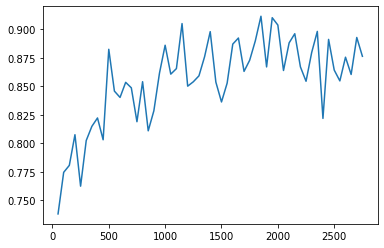

[ $$$ ] TEST


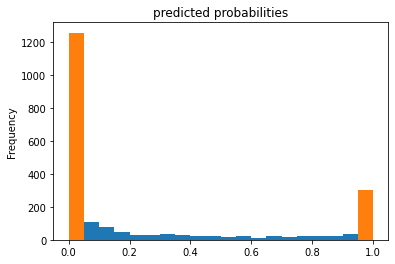

[ *** ] STEP MAX: 2800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.891250
accuracy_baseline          0.531250
auc                        0.962400
auc_precision_recall       0.955230
average_loss               0.267641
label/mean                 0.468750
loss                       0.428225
precision                  0.921053
prediction/mean            0.412083
recall                     0.840000
global_step             2800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8882352941176471
[ $ ] VALIDATION ACCURACY OVER TIME: 


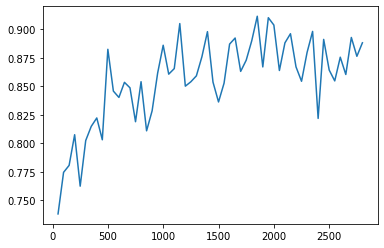

[ $$$ ] TEST


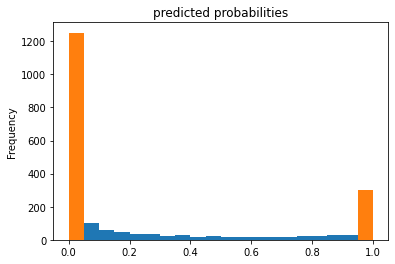

[ *** ] STEP MAX: 2850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.917513
accuracy_baseline          0.543147
auc                        0.970730
auc_precision_recall       0.964149
average_loss               0.228352
label/mean                 0.456853
loss                       0.359882
precision                  0.927536
prediction/mean            0.422809
recall                     0.888889
global_step             2850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9152388369678089
[ $ ] VALIDATION ACCURACY OVER TIME: 


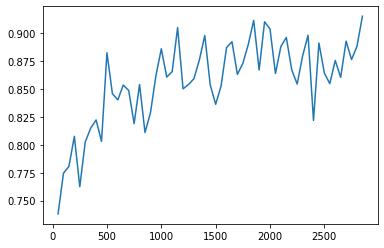

[ $$$ ] TEST


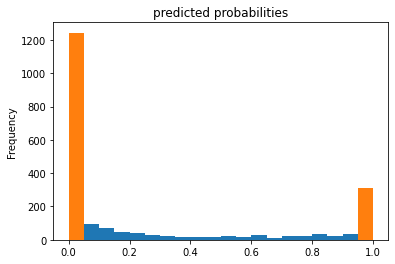

[ *** ] STEP MAX: 2900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.891192
accuracy_baseline          0.559586
auc                        0.967559
auc_precision_recall       0.958989
average_loss               0.231385
label/mean                 0.440415
loss                       0.357258
precision                  0.895062
prediction/mean            0.419089
recall                     0.852941
global_step             2900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8871187363834422
[ $ ] VALIDATION ACCURACY OVER TIME: 


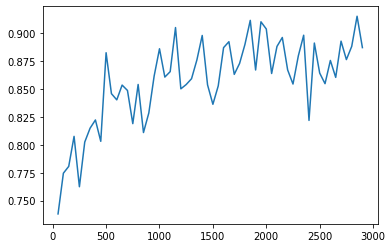

[ $$$ ] TEST


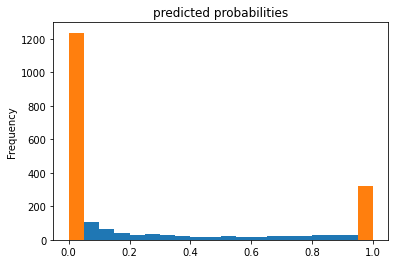

[ *** ] STEP MAX: 2950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.881980
accuracy_baseline          0.543147
auc                        0.967679
auc_precision_recall       0.960550
average_loss               0.235549
label/mean                 0.456853
loss                       0.371226
precision                  0.913313
prediction/mean            0.417834
recall                     0.819444
global_step             2950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8770119418483905
[ $ ] VALIDATION ACCURACY OVER TIME: 


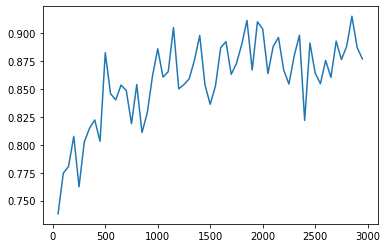

[ $$$ ] TEST


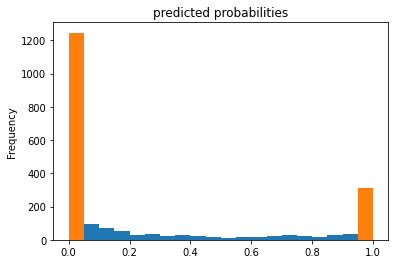

[ *** ] STEP MAX: 3000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.875000
accuracy_baseline          0.531250
auc                        0.958337
auc_precision_recall       0.946412
average_loss               0.278820
label/mean                 0.468750
loss                       0.446112
precision                  0.910448
prediction/mean            0.415425
recall                     0.813333
global_step             3000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8713725490196079
[ $ ] VALIDATION ACCURACY OVER TIME: 


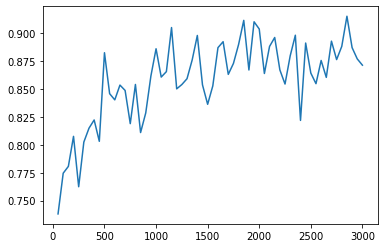

[ $$$ ] TEST


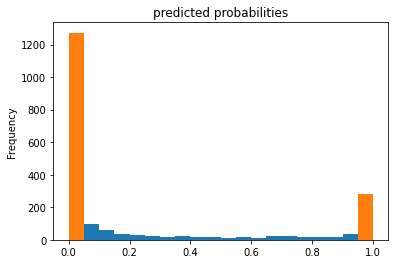

[ *** ] STEP MAX: 3050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.889706
accuracy_baseline          0.515931
auc                        0.967979
auc_precision_recall       0.965814
average_loss               0.228191
label/mean                 0.484069
loss                       0.372408
precision                  0.876543
prediction/mean            0.488978
recall                     0.898734
global_step             3050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8899846658047446
[ $ ] VALIDATION ACCURACY OVER TIME: 


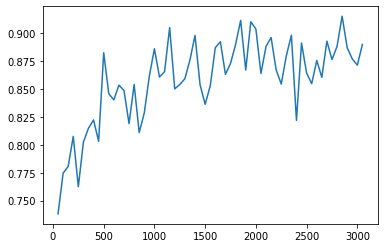

[ $$$ ] TEST


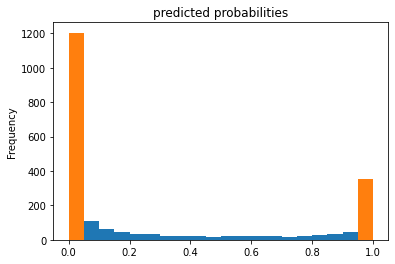

[ *** ] STEP MAX: 3100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.897668
accuracy_baseline          0.559586
auc                        0.970588
auc_precision_recall       0.963407
average_loss               0.214971
label/mean                 0.440415
loss                       0.331916
precision                  0.884956
prediction/mean            0.440785
recall                     0.882353
global_step             3100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8960375816993464
[ $ ] VALIDATION ACCURACY OVER TIME: 


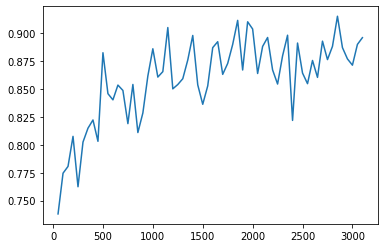

[ $$$ ] TEST


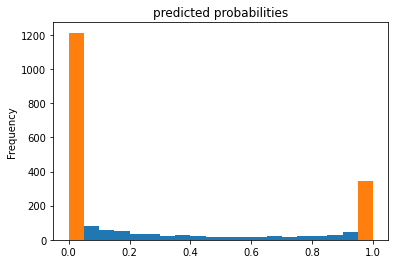

[ *** ] STEP MAX: 3150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.895380
accuracy_baseline          0.599185
auc                        0.966313
auc_precision_recall       0.943953
average_loss               0.234276
label/mean                 0.400815
loss                       0.344854
precision                  0.860927
prediction/mean            0.402572
recall                     0.881356
global_step             3150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8930589184826474
[ $ ] VALIDATION ACCURACY OVER TIME: 


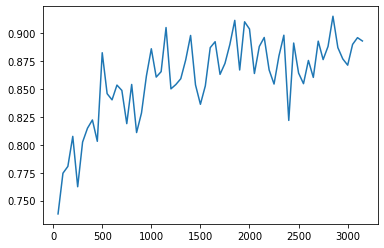

[ $$$ ] TEST


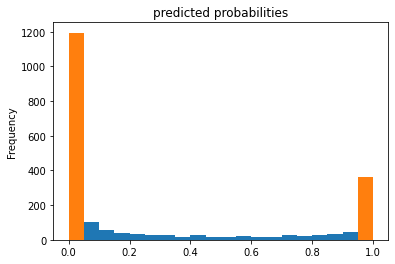

[ *** ] STEP MAX: 3200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.875000
accuracy_baseline          0.555412
auc                        0.958321
auc_precision_recall       0.941701
average_loss               0.273875
label/mean                 0.444588
loss                       0.425054
precision                  0.897436
prediction/mean            0.404332
recall                     0.811594
global_step             3200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8686741316116884
[ $ ] VALIDATION ACCURACY OVER TIME: 


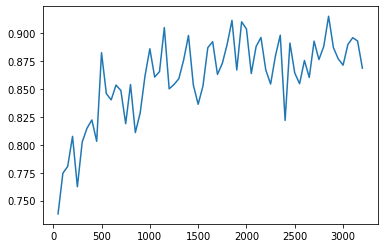

[ $$$ ] TEST


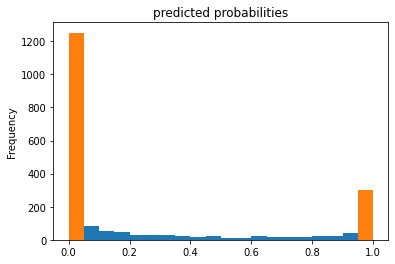

[ *** ] STEP MAX: 3250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.909091
accuracy_baseline          0.539141
auc                        0.973549
auc_precision_recall       0.971041
average_loss               0.207872
label/mean                 0.460859
loss                       0.329269
precision                  0.910364
prediction/mean            0.450781
recall                     0.890411
global_step             3250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9077347534567386
[ $ ] VALIDATION ACCURACY OVER TIME: 


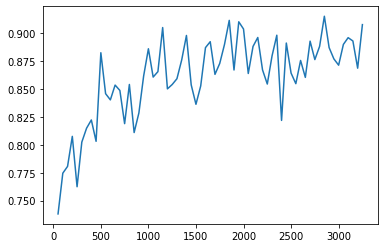

[ $$$ ] TEST


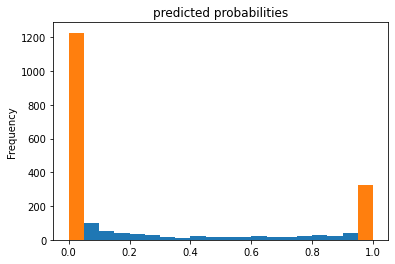

[ *** ] STEP MAX: 3300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.887056
accuracy_baseline          0.543147
auc                        0.962730
auc_precision_recall       0.949584
average_loss               0.257127
label/mean                 0.456853
loss                       0.405232
precision                  0.899705
prediction/mean            0.420655
recall                     0.847222
global_step             3300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8838914849428868
[ $ ] VALIDATION ACCURACY OVER TIME: 


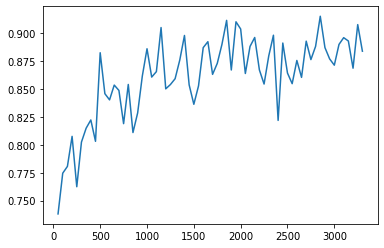

[ $$$ ] TEST


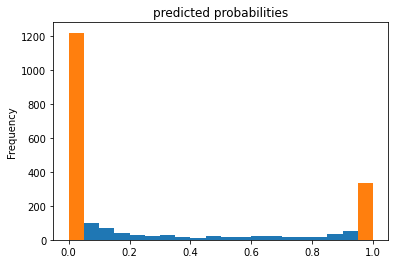

[ *** ] STEP MAX: 3350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.927296
accuracy_baseline          0.547194
auc                        0.976033
auc_precision_recall       0.963829
average_loss               0.188648
label/mean                 0.452806
loss                       0.295801
precision                  0.900538
prediction/mean            0.457704
recall                     0.943662
global_step             3350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9287074427919499
[ $ ] VALIDATION ACCURACY OVER TIME: 


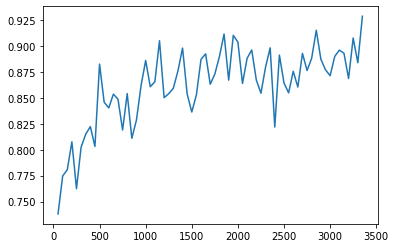

[ $$$ ] TEST


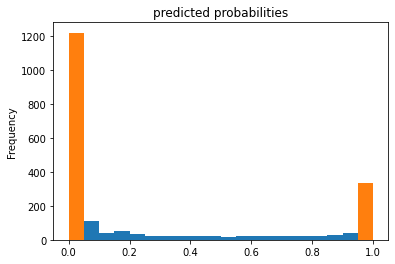

[ *** ] STEP MAX: 3400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.906250
accuracy_baseline          0.531250
auc                        0.973631
auc_precision_recall       0.965325
average_loss               0.205520
label/mean                 0.468750
loss                       0.328832
precision                  0.894737
prediction/mean            0.470765
recall                     0.906667
global_step             3400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9062745098039215
[ $ ] VALIDATION ACCURACY OVER TIME: 


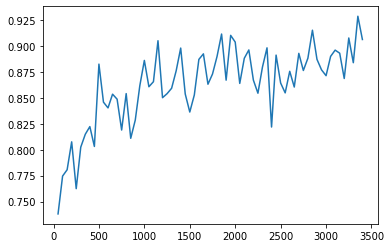

[ $$$ ] TEST


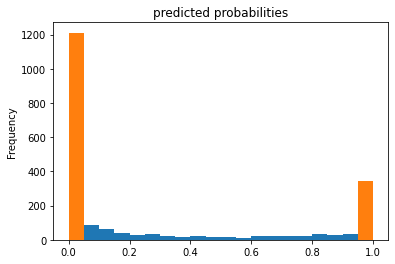

[ *** ] STEP MAX: 3450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.925258
accuracy_baseline          0.555412
auc                        0.977000
auc_precision_recall       0.967763
average_loss               0.203417
label/mean                 0.444588
loss                       0.315703
precision                  0.930931
prediction/mean            0.415333
recall                     0.898551
global_step             3450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.922593227748075
[ $ ] VALIDATION ACCURACY OVER TIME: 


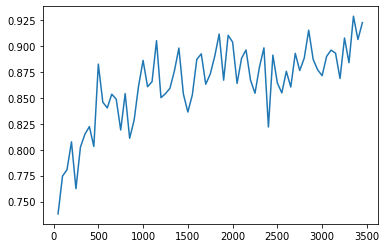

[ $$$ ] TEST


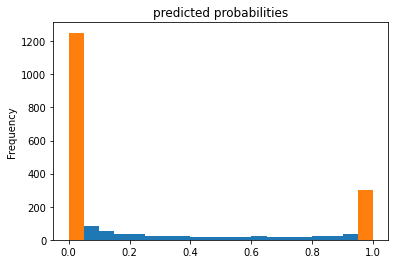

[ *** ] STEP MAX: 3500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.918394
accuracy_baseline          0.559586
auc                        0.973431
auc_precision_recall       0.959476
average_loss               0.204927
label/mean                 0.440415
loss                       0.316407
precision                  0.903790
prediction/mean            0.407106
recall                     0.911765
global_step             3500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.917687908496732
[ $ ] VALIDATION ACCURACY OVER TIME: 


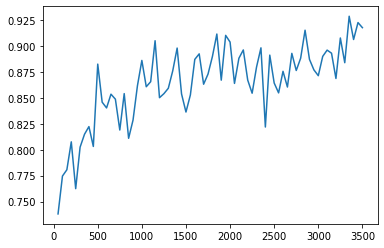

[ $$$ ] TEST


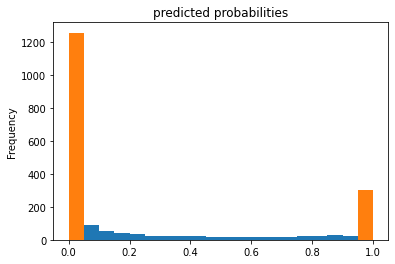

[ *** ] STEP MAX: 3550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.890052
accuracy_baseline          0.568063
auc                        0.970360
auc_precision_recall       0.956416
average_loss               0.224092
label/mean                 0.431937
loss                       0.342413
precision                  0.857558
prediction/mean            0.439202
recall                     0.893939
global_step             3550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8905180840664711
[ $ ] VALIDATION ACCURACY OVER TIME: 


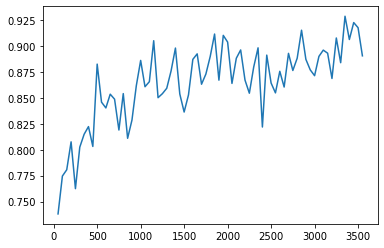

[ $$$ ] TEST


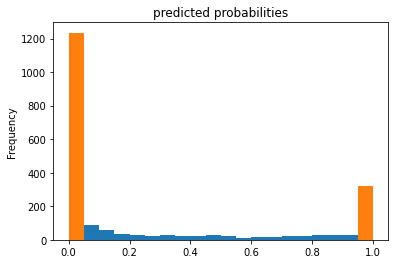

[ *** ] STEP MAX: 3600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.914103
accuracy_baseline          0.551282
auc                        0.969369
auc_precision_recall       0.961485
average_loss               0.233529
label/mean                 0.448718
loss                       0.364305
precision                  0.907781
prediction/mean            0.420595
recall                     0.900000
global_step             3600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9127906976744187
[ $ ] VALIDATION ACCURACY OVER TIME: 


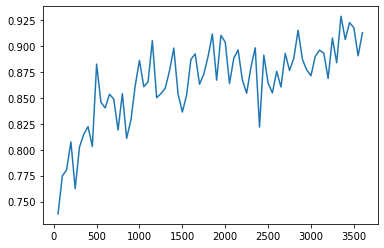

[ $$$ ] TEST


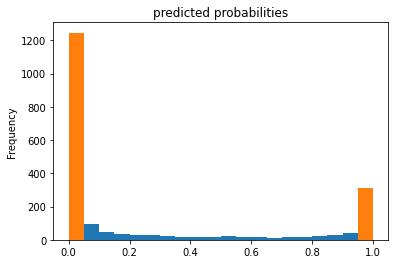

[ *** ] STEP MAX: 3650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.899321
accuracy_baseline          0.542986
auc                        0.971625
auc_precision_recall       0.975373
average_loss               0.253394
label/mean                 0.542986
loss                       0.448001
precision                  0.955711
prediction/mean            0.469157
recall                     0.854167
global_step             3650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9035684818481847
[ $ ] VALIDATION ACCURACY OVER TIME: 


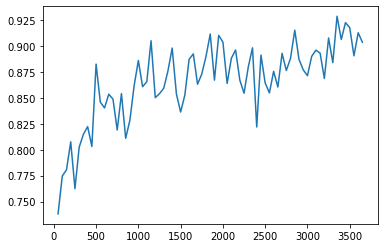

[ $$$ ] TEST


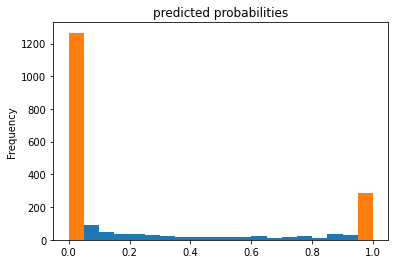

[ *** ] STEP MAX: 3700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.903553
accuracy_baseline          0.543147
auc                        0.968442
auc_precision_recall       0.963404
average_loss               0.228892
label/mean                 0.456853
loss                       0.360733
precision                  0.898876
prediction/mean            0.444077
recall                     0.888889
global_step             3700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9023883696780892
[ $ ] VALIDATION ACCURACY OVER TIME: 


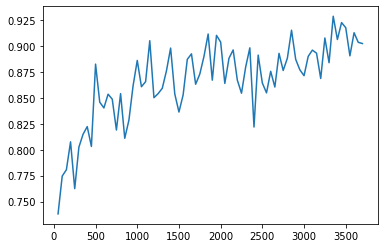

[ $$$ ] TEST


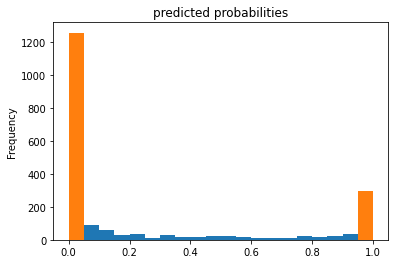

[ *** ] STEP MAX: 3750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.911168
accuracy_baseline          0.543147
auc                        0.969188
auc_precision_recall       0.958740
average_loss               0.239746
label/mean                 0.456853
loss                       0.377839
precision                  0.926471
prediction/mean            0.410483
recall                     0.875000
global_step             3750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9082943925233644
[ $ ] VALIDATION ACCURACY OVER TIME: 


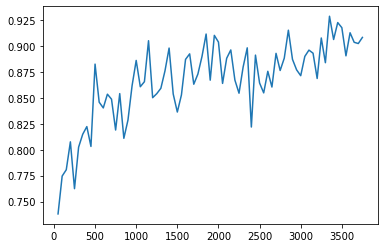

[ $$$ ] TEST


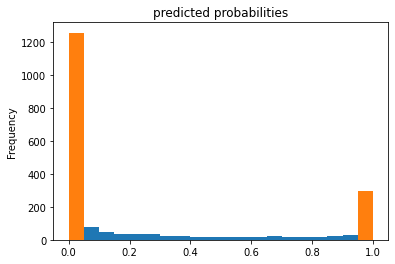

[ *** ] STEP MAX: 3800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.913660
accuracy_baseline          0.555412
auc                        0.979858
auc_precision_recall       0.975111
average_loss               0.190552
label/mean                 0.444588
loss                       0.295737
precision                  0.945513
prediction/mean            0.408720
recall                     0.855072
global_step             3800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9078146541578399
[ $ ] VALIDATION ACCURACY OVER TIME: 


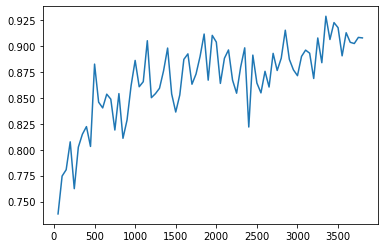

[ $$$ ] TEST


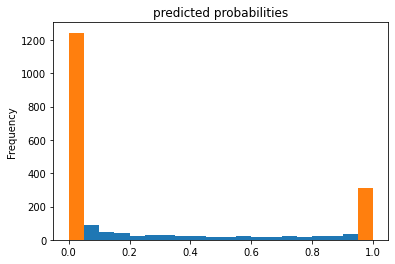

[ *** ] STEP MAX: 3850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.922030
accuracy_baseline          0.523515
auc                        0.981103
auc_precision_recall       0.978044
average_loss               0.179624
label/mean                 0.476485
loss                       0.290273
precision                  0.925926
prediction/mean            0.450203
recall                     0.909091
global_step             3850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9214485278315065
[ $ ] VALIDATION ACCURACY OVER TIME: 


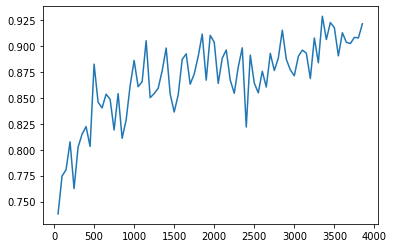

[ $$$ ] TEST


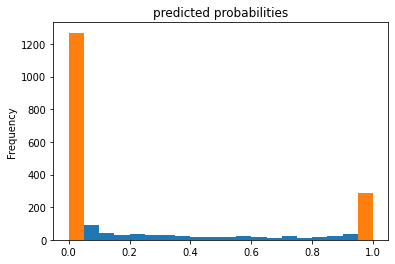

[ *** ] STEP MAX: 3900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.902344
accuracy_baseline          0.563802
auc                        0.977508
auc_precision_recall       0.971266
average_loss               0.193049
label/mean                 0.436198
loss                       0.296524
precision                  0.882353
prediction/mean            0.432004
recall                     0.895522
global_step             3900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9015718175864328
[ $ ] VALIDATION ACCURACY OVER TIME: 


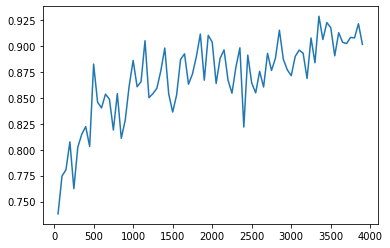

[ $$$ ] TEST


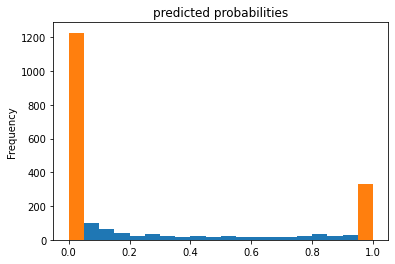

[ *** ] STEP MAX: 3950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.910995
accuracy_baseline          0.568063
auc                        0.971408
auc_precision_recall       0.962005
average_loss               0.218214
label/mean                 0.431937
loss                       0.333432
precision                  0.899390
prediction/mean            0.417079
recall                     0.893939
global_step             3950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9089512637899735
[ $ ] VALIDATION ACCURACY OVER TIME: 


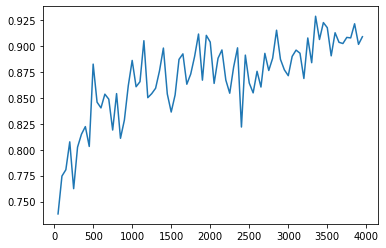

[ $$$ ] TEST


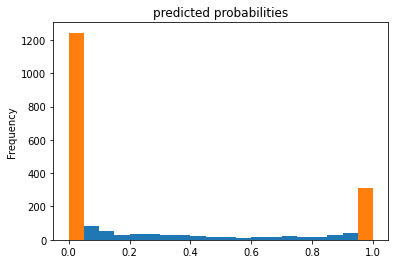

[ *** ] STEP MAX: 4000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.924359
accuracy_baseline          0.551282
auc                        0.977940
auc_precision_recall       0.974668
average_loss               0.197175
label/mean                 0.448718
loss                       0.307593
precision                  0.929204
prediction/mean            0.423932
recall                     0.900000
global_step             4000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9220930232558139
[ $ ] VALIDATION ACCURACY OVER TIME: 


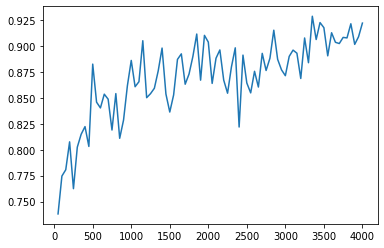

[ $$$ ] TEST


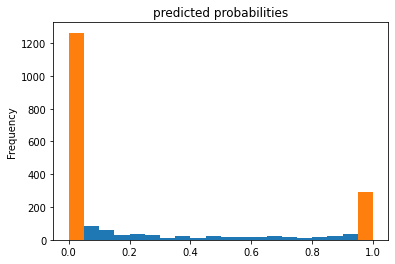

[ *** ] STEP MAX: 4050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.899498
accuracy_baseline          0.535176
auc                        0.972085
auc_precision_recall       0.970136
average_loss               0.231142
label/mean                 0.464824
loss                       0.367978
precision                  0.939394
prediction/mean            0.419118
recall                     0.837838
global_step             4050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8954447405151632
[ $ ] VALIDATION ACCURACY OVER TIME: 


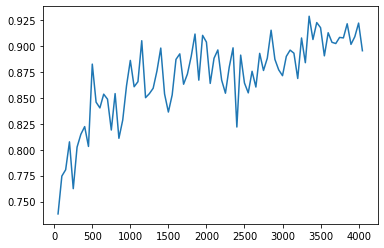

[ $$$ ] TEST


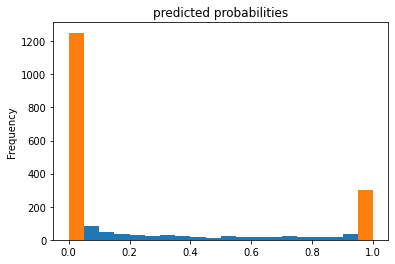

[ *** ] STEP MAX: 4100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.908974
accuracy_baseline          0.551282
auc                        0.971445
auc_precision_recall       0.966269
average_loss               0.226792
label/mean                 0.448718
loss                       0.353796
precision                  0.921450
prediction/mean            0.413783
recall                     0.871429
global_step             4100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9054817275747509
[ $ ] VALIDATION ACCURACY OVER TIME: 


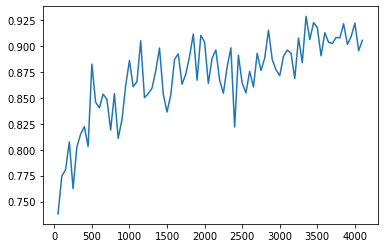

[ $$$ ] TEST


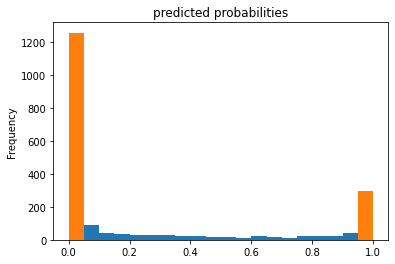

[ *** ] STEP MAX: 4150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.915000
accuracy_baseline          0.531250
auc                        0.968894
auc_precision_recall       0.962871
average_loss               0.224640
label/mean                 0.468750
loss                       0.359423
precision                  0.911528
prediction/mean            0.445302
recall                     0.906667
global_step             4150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9145098039215687
[ $ ] VALIDATION ACCURACY OVER TIME: 


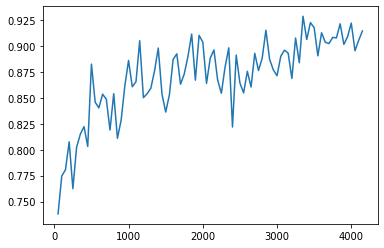

[ $$$ ] TEST


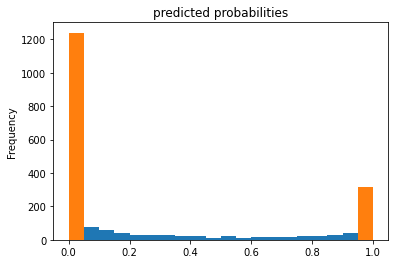

[ *** ] STEP MAX: 4200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.878750
accuracy_baseline          0.531250
auc                        0.968643
auc_precision_recall       0.965672
average_loss               0.237796
label/mean                 0.468750
loss                       0.380473
precision                  0.931677
prediction/mean            0.421041
recall                     0.800000
global_step             4200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8741176470588236
[ $ ] VALIDATION ACCURACY OVER TIME: 


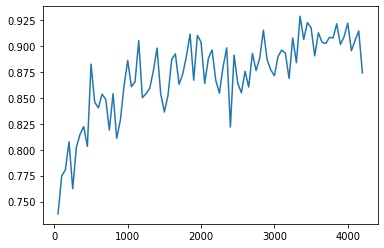

[ $$$ ] TEST


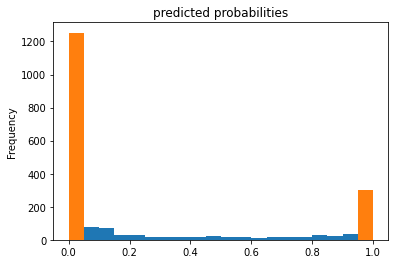

[ *** ] STEP MAX: 4250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.899485
accuracy_baseline          0.555412
auc                        0.973183
auc_precision_recall       0.964929
average_loss               0.213987
label/mean                 0.444588
loss                       0.332108
precision                  0.913313
prediction/mean            0.415165
recall                     0.855072
global_step             4250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8950536332761693
[ $ ] VALIDATION ACCURACY OVER TIME: 


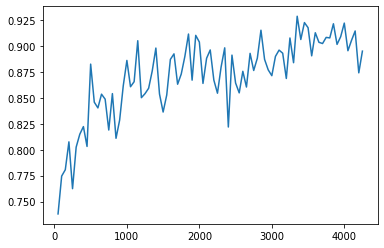

[ $$$ ] TEST


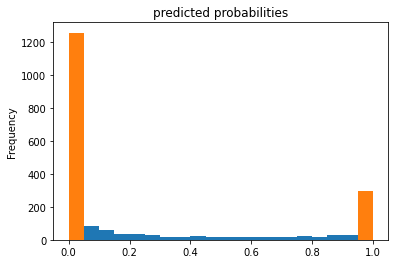

[ *** ] STEP MAX: 4300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.932927
accuracy_baseline          0.512195
auc                        0.975640
auc_precision_recall       0.972478
average_loss               0.202231
label/mean                 0.487805
loss                       0.331658
precision                  0.925926
prediction/mean            0.456499
recall                     0.937500
global_step             4300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9330357142857142
[ $ ] VALIDATION ACCURACY OVER TIME: 


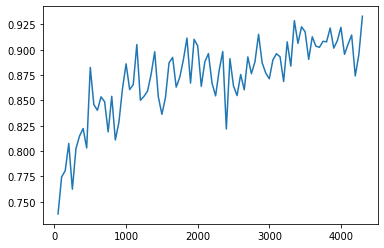

[ $$$ ] TEST


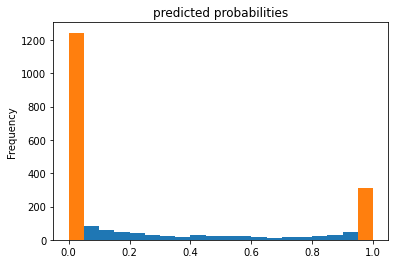

[ *** ] STEP MAX: 4350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.929087
accuracy_baseline          0.501202
auc                        0.982260
auc_precision_recall       0.978297
average_loss               0.187367
label/mean                 0.498798
loss                       0.311779
precision                  0.951777
prediction/mean            0.454719
recall                     0.903614
global_step             4350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9290254543353269
[ $ ] VALIDATION ACCURACY OVER TIME: 


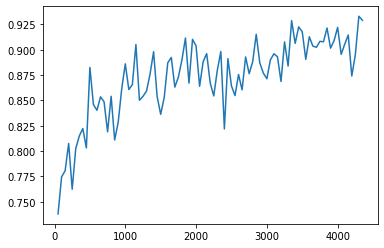

[ $$$ ] TEST


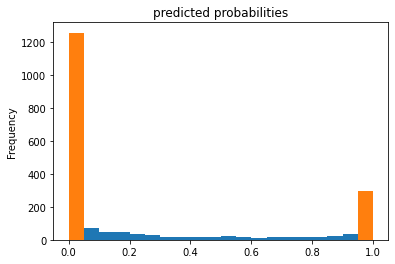

[ *** ] STEP MAX: 4400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.884021
accuracy_baseline          0.555412
auc                        0.962339
auc_precision_recall       0.947468
average_loss               0.263650
label/mean                 0.444588
loss                       0.409184
precision                  0.892308
prediction/mean            0.419812
recall                     0.840580
global_step             4400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.879686606812603
[ $ ] VALIDATION ACCURACY OVER TIME: 


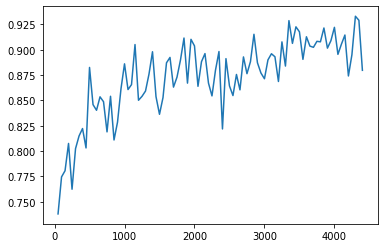

[ $$$ ] TEST


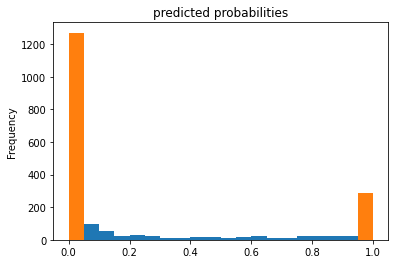

[ *** ] STEP MAX: 4450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.915789
accuracy_baseline          0.572368
auc                        0.975738
auc_precision_recall       0.969202
average_loss               0.203658
label/mean                 0.427632
loss                       0.309561
precision                  0.896657
prediction/mean            0.435816
recall                     0.907692
global_step             4450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9147656940760389
[ $ ] VALIDATION ACCURACY OVER TIME: 


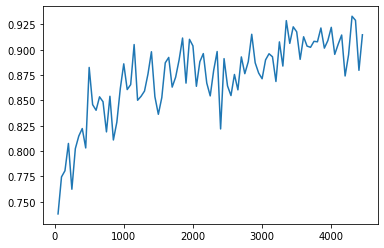

[ $$$ ] TEST


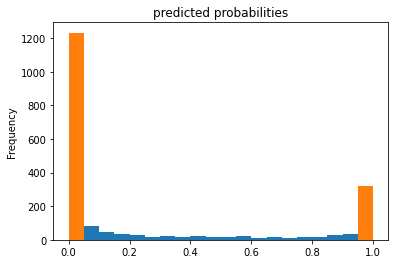

[ *** ] STEP MAX: 4500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.914948
accuracy_baseline          0.555412
auc                        0.976226
auc_precision_recall       0.969300
average_loss               0.194275
label/mean                 0.444588
loss                       0.301514
precision                  0.897436
prediction/mean            0.439547
recall                     0.913043
global_step             4500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9147583980631493
[ $ ] VALIDATION ACCURACY OVER TIME: 


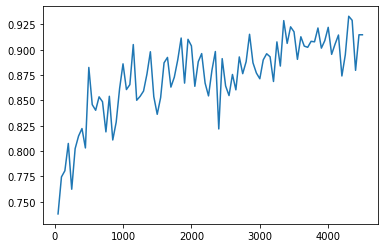

[ $$$ ] TEST


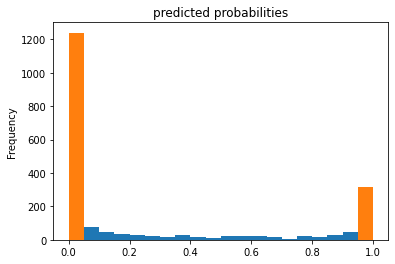

[ *** ] STEP MAX: 4550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.932741
accuracy_baseline          0.543147
auc                        0.979946
auc_precision_recall       0.974734
average_loss               0.181656
label/mean                 0.456853
loss                       0.286289
precision                  0.934844
prediction/mean            0.431605
recall                     0.916667
global_step             4550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9314641744548287
[ $ ] VALIDATION ACCURACY OVER TIME: 


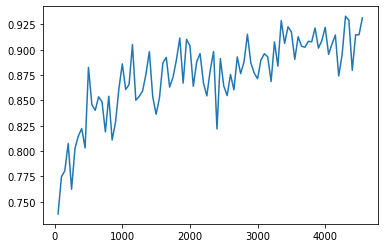

[ $$$ ] TEST


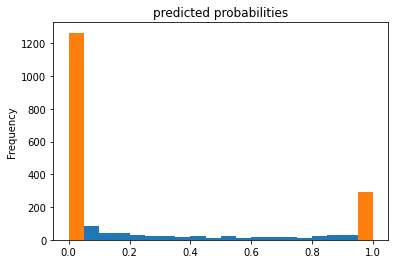

[ *** ] STEP MAX: 4600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.933750
accuracy_baseline          0.531250
auc                        0.977192
auc_precision_recall       0.968344
average_loss               0.190764
label/mean                 0.468750
loss                       0.305222
precision                  0.914948
prediction/mean            0.472589
recall                     0.946667
global_step             4600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9345098039215686
[ $ ] VALIDATION ACCURACY OVER TIME: 


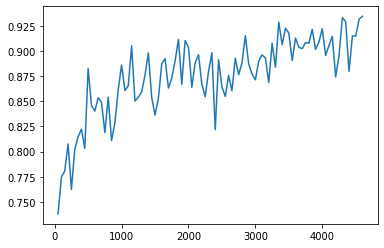

[ $$$ ] TEST


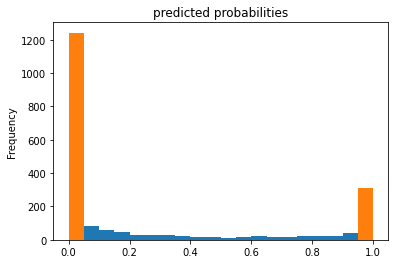

[ *** ] STEP MAX: 4650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.913317
accuracy_baseline          0.535176
auc                        0.975923
auc_precision_recall       0.972669
average_loss               0.211851
label/mean                 0.464824
loss                       0.337267
precision                  0.919220
prediction/mean            0.437079
recall                     0.891892
global_step             4650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9119083872604999
[ $ ] VALIDATION ACCURACY OVER TIME: 


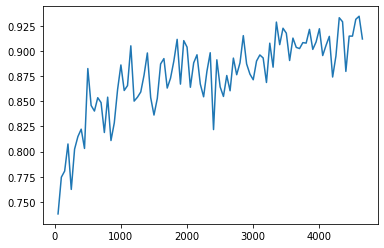

[ $$$ ] TEST


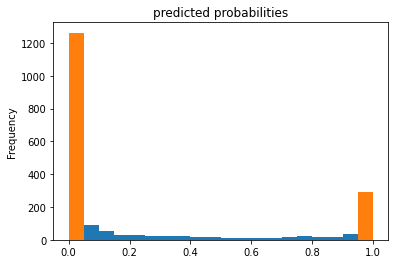

[ *** ] STEP MAX: 4700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.917539
accuracy_baseline          0.568063
auc                        0.983243
auc_precision_recall       0.976356
average_loss               0.166320
label/mean                 0.431937
loss                       0.254137
precision                  0.900901
prediction/mean            0.437949
recall                     0.909091
global_step             4700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9165270213657312
[ $ ] VALIDATION ACCURACY OVER TIME: 


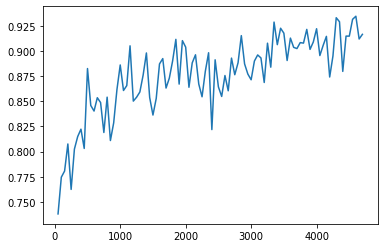

[ $$$ ] TEST


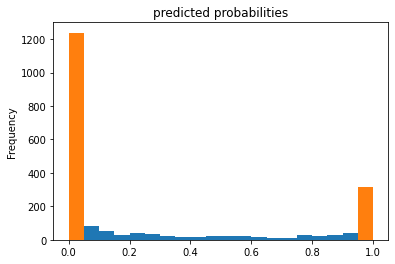

[ *** ] STEP MAX: 4750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.906085
accuracy_baseline          0.576720
auc                        0.980003
auc_precision_recall       0.967525
average_loss               0.177118
label/mean                 0.423280
loss                       0.267803
precision                  0.900322
prediction/mean            0.413570
recall                     0.875000
global_step             4750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9019495412844037
[ $ ] VALIDATION ACCURACY OVER TIME: 


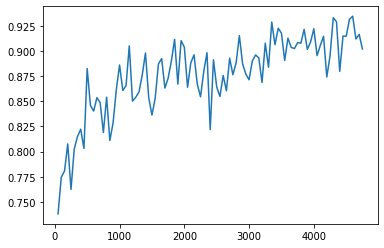

[ $$$ ] TEST


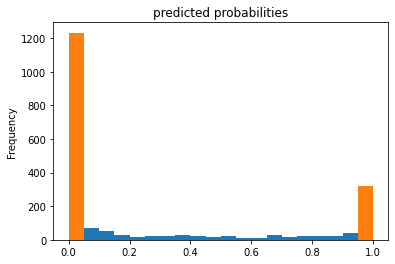

[ *** ] STEP MAX: 4800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.947236
accuracy_baseline          0.535176
auc                        0.988342
auc_precision_recall       0.986343
average_loss               0.143211
label/mean                 0.464824
loss                       0.227993
precision                  0.940860
prediction/mean            0.448352
recall                     0.945946
global_step             4800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9471513767288415
[ $ ] VALIDATION ACCURACY OVER TIME: 


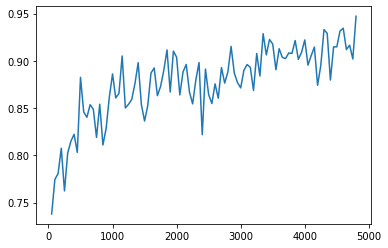

[ $$$ ] TEST


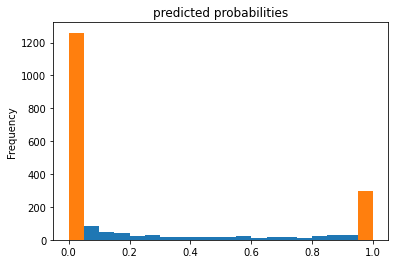

[ *** ] STEP MAX: 4850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.943467
accuracy_baseline          0.535176
auc                        0.984345
auc_precision_recall       0.977552
average_loss               0.164538
label/mean                 0.464824
loss                       0.261945
precision                  0.945205
prediction/mean            0.435012
recall                     0.932432
global_step             4850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9427420378124605
[ $ ] VALIDATION ACCURACY OVER TIME: 


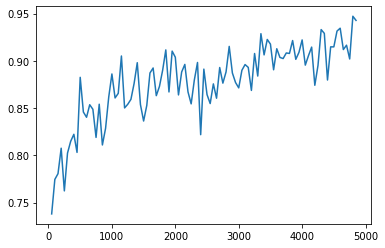

[ $$$ ] TEST


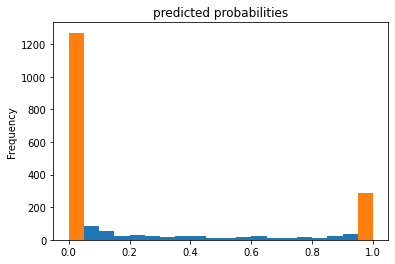

[ *** ] STEP MAX: 4900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.903110
accuracy_baseline          0.502392
auc                        0.977221
auc_precision_recall       0.973816
average_loss               0.212345
label/mean                 0.502392
loss                       0.355040
precision                  0.933504
prediction/mean            0.452213
recall                     0.869048
global_step             4900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9032738095238094
[ $ ] VALIDATION ACCURACY OVER TIME: 


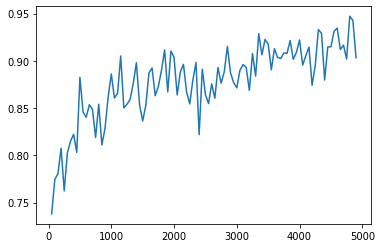

[ $$$ ] TEST


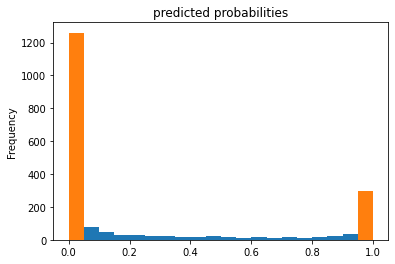

[ *** ] STEP MAX: 4950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.916667
accuracy_baseline          0.551282
auc                        0.977409
auc_precision_recall       0.966036
average_loss               0.193529
label/mean                 0.448718
loss                       0.301905
precision                  0.925373
prediction/mean            0.420381
recall                     0.885714
global_step             4950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9137873754152824
[ $ ] VALIDATION ACCURACY OVER TIME: 


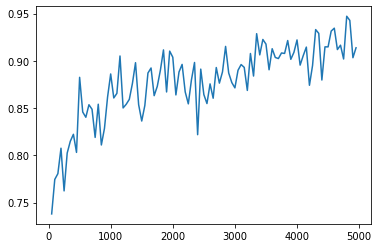

[ $$$ ] TEST


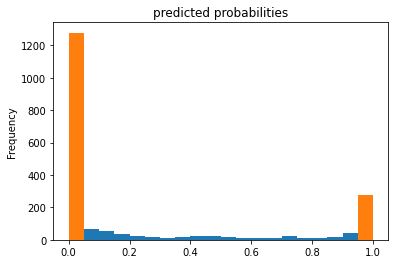

[ *** ] STEP MAX: 5000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.917098
accuracy_baseline          0.559586
auc                        0.979064
auc_precision_recall       0.967899
average_loss               0.177802
label/mean                 0.440415
loss                       0.274527
precision                  0.913174
prediction/mean            0.430770
recall                     0.897059
global_step             5000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9149645969498911
[ $ ] VALIDATION ACCURACY OVER TIME: 


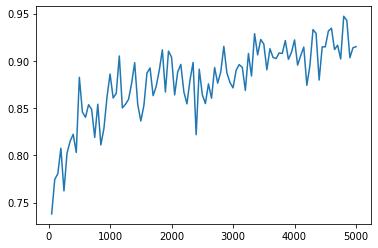

[ $$$ ] TEST


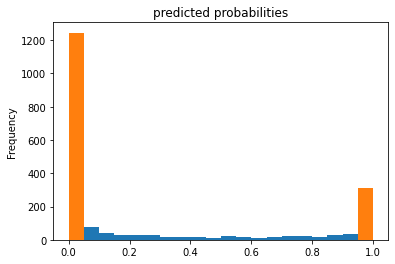

In [123]:
# CREATIVE MODEL

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))
DNN_NUMERIC_COLUMNS = []
DNN_NUMERIC_COLUMNS = ['neigh_vote', 'neigh_swing', 'neigh_pop']
dnn_feature_cols = feature_columns

# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

# Training and evaluation input functions.
og_train_input_fn = make_input_fn(train_x, train_y, shuffle=False, n_epochs=1)
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
test_input_fn = make_input_fn(test_x, None, shuffle=False, n_epochs=1)

# (k-1)/k size MINI BATCHING
trains = []
vals = []
k = 5
splitter = 1555//k
split_index = [splitter*i for i in range(k)]
back_idx = [splitter*(i+1) for i in range(k)]
back_idx[-1] = 1555
yvals = []

train_x1 = train_x
train_y1 = train_y

for i in range(k):
    train_x = train_x1.copy()
    train_y = train_y1.copy()
    tdf = pd.concat([train_x.iloc[:split_index[i],:], train_x.iloc[back_idx[i]:,:]])
    ty = pd.concat([train_y.iloc[:split_index[i]], train_y.iloc[back_idx[i]:]])
    
    df = train_x.iloc[split_index[i]:back_idx[i],:]
    y = train_y.iloc[split_index[i]:back_idx[i]]
    
    trains.append(make_input_fn(tdf, ty, shuffle = False))
    vals.append(make_input_fn(df,y,shuffle=False, n_epochs=1))
    yvals.append(y)

'''
Since data fits into memory, use entire dataset per layer. It will be faster.
Above one batch is defined as the entire dataset.
'''

weight_col = 'Weight'

# DNN??
est = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=feature_columns,
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,  
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = 'Weight',
    dnn_dropout = None,
    batch_norm = False
)

_run = True
n = 0
i = 3

accs = []
ns = []

# MINI BATCH SETUP
batch_size = 500
indices = [x for x in range(1555)]

while _run:
    incr = 50
    n += incr
    
    # EARLY STOPPING
    if n > 1600:
        break

    print(f"[ *** ] STEP MAX: {n}")

    # BATCH SELECTOR
    i += 1
    i = i%k
    
    batch_x, batch_y, valid_x, valid_y = generate_mini_batch(trimmed_data_frame, num_rows = batch_size)
    train_input_fn = make_input_fn(batch_x, batch_y, shuffle=True)
    eval_input_fn  = make_input_fn(valid_x, valid_y, shuffle=False, n_epochs=1)
    
    print("[ $$$ ] TRAINING")
    # Train up to n steps
    est.train(train_input_fn, max_steps=n)
    
    # Have the model predict on a validation set to estimate performance
    print("[ $$$ ] EVAL RESULTS:")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
    print(pd.Series(result))

    # Given the prediction dictionaries, process them into parseable form
    eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])
    eval_submission = cthresh(eval_preds, thresh = 0.5)
    
    # Calculate weighted accuracy on validation
    w_acc = weighted_accuracy(eval_submission, valid_y)
    
    # Append to list of running weighted accuracies
    accs.append(w_acc)
        
    print("[ $ ] WEIGHTED ACCURACY ON VALIDATION: ")
    print(w_acc)
    
    # Create a graph over time of validation accuracy
    print("[ $ ] VALIDATION ACCURACY OVER TIME: ")
    ns.append(n)
    plt.plot(ns,accs)
    plt.show()
    
    # Generate prediction on the test set
    print("[ $$$ ] TEST")
    pred_dicts = list(est.predict(test_input_fn))
    
    # Extract the prediction from model output
    preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    # Create histogram of the predictions
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    
    # Create a histogram of submission statistics
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    plt.show()
 
    # Package submission 
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>